# Unified AML/MDS Chimerism Dynamics Analysis

## Comprehensive Analysis of CD3+ Chimerism Patterns and Clinical Outcomes

This notebook provides a unified analysis framework for investigating CD3+ chimerism dynamics and their association with multiple clinical outcomes in AML/MDS patients post-transplant.

### Primary Outcomes Analyzed:
- **y_death**: Overall survival (mortality)
- **y_relapse**: Disease relapse 
- **y_rfs**: Relapse-free survival
- **y_agvhd**: Acute graft-versus-host disease
- **y_cgvhd**: Chronic graft-versus-host disease

### Analysis Framework:
1. **Essential Visualizations**: Individual trajectories, change magnitude analysis, pattern classification
2. **Advanced Analytics**: Survival analysis, comparative CD3+/CD3- analysis, comprehensive statistical testing
3. **Clinical Translation**: Risk prediction models, subgroup analysis, interaction effects

### Key Features:
- Multi-outcome support with automated analysis across all endpoints
- Optimized and refactored code for better performance and maintainability
- Comprehensive statistical testing and effect size calculations
- Machine learning-based risk prediction and feature importance analysis
- Clinical decision support tools and visualization

## 1. Environment Setup and Library Imports

Import all necessary libraries for data processing, machine learning, and visualization.

In [14]:
# Core data processing libraries
import pandas as pd
import numpy as np
import logging
import sys
import warnings
import os
import joblib
from datetime import datetime

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
# Enable experimental features for IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, RFE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Advanced clustering and dimensionality reduction
try:
    import umap.umap_ as umap
    UMAP_AVAILABLE = True
except ImportError:
    print("⚠️ UMAP not available. Install with: pip install umap-learn")
    UMAP_AVAILABLE = False

try:
    import skfuzzy as fuzz
    from skfuzzy import cmeans
    FUZZY_AVAILABLE = True
except ImportError:
    print("⚠️ scikit-fuzzy not available. Install with: pip install scikit-fuzzy")
    FUZZY_AVAILABLE = False

# Genetic algorithm
try:
    from deap import base, creator, tools, algorithms
    import random
    GA_AVAILABLE = True
except ImportError:
    print("⚠️ DEAP not available. Install with: pip install deap")
    GA_AVAILABLE = False

# Configuration
warnings.filterwarnings("ignore")
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(message)s", force=True)
np.random.seed(42)
if GA_AVAILABLE:
    random.seed(42)

# Plotting configuration
plt.style.use('default')
sns.set_palette("husl")

print("✅ Core libraries imported successfully")
if UMAP_AVAILABLE:
    print("✅ UMAP available for dimensionality reduction")
if FUZZY_AVAILABLE:
    print("✅ Fuzzy clustering available")
if GA_AVAILABLE:
    print("✅ Genetic algorithms available")

print(f"📅 Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Core libraries imported successfully
✅ UMAP available for dimensionality reduction
✅ Fuzzy clustering available
✅ Genetic algorithms available
📅 Analysis started at: 2025-07-22 00:53:31


## 2. Data Loading and Excel Column Mapping

Load the dataset with proper Excel column mapping for consistency.

In [15]:
def load_data(file_path="main_dataset.xlsx", sheet_name="Sheet1", skip_rows=2):
    """
    Load dataset from Excel file with proper handling of headers and empty rows.
    
    For CSV files, use pd.read_csv() instead.
    """
    logging.info("Loading dataset...")
    
    # Try loading as Excel first, then CSV if that fails
    try:
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_path)
        else:
            df = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=skip_rows)
    except FileNotFoundError:
        # Try loading the preprocessed CSV file
        logging.info("Excel file not found, trying preprocessed CSV...")
        df = pd.read_csv("preprocessed_ml_for_aml_mds.csv")
    
    # Remove completely empty rows
    df.dropna(axis=0, how='all', inplace=True)
    
    logging.info(f"Dataset loaded successfully. Shape: {df.shape}")
    return df

def map_excel_columns(df):
    """
    Create a mapping from Excel column letters (A, B, C...) to actual column names.
    """
    column_mapping = {}
    for idx, col_name in enumerate(df.columns):
        col_letter = ""
        col_number = idx + 1
        while col_number > 0:
            col_number, remainder = divmod(col_number - 1, 26)
            col_letter = chr(65 + remainder) + col_letter
        column_mapping[col_letter] = col_name
    return column_mapping

# Load the dataset
df = load_data(file_path="preprocessed_ml_for_aml_mds.csv", sheet_name="Sheet1", skip_rows=2)
excel_column_mapping = map_excel_columns(df)

# Display basic information
print(f"\n=== Dataset Overview ===")
print(f"Total rows: {len(df):,}")
print(f"Total columns: {len(df.columns):,}")
print(f"Total missing values: {df.isnull().sum().sum():,}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Show column types
print(f"\nData types:")
print(df.dtypes.value_counts())

# Identify key columns
chimerism_cols = [col for col in df.columns if 'cd3' in col.lower()]
outcome_cols = [col for col in df.columns if col.startswith('y_')]

print(f"\nKey columns identified:")
print(f"  - Chimerism columns ({len(chimerism_cols)}): {chimerism_cols[:5]}...")
print(f"  - Outcome columns ({len(outcome_cols)}): {outcome_cols[:5]}...")

# Display first few rows
print(f"\n=== First 3 Rows ===")
display(df.head(3))

Loading dataset...
Dataset loaded successfully. Shape: (258, 64)

=== Dataset Overview ===
Total rows: 258
Total columns: 64
Total missing values: 3,634
Memory usage: 0.22 MB

Data types:
float64    31
int64      24
object      9
Name: count, dtype: int64

Key columns identified:
  - Chimerism columns (7): ['cd34+_dose', 'd30_cd3+', 'd30_cd3-', 'd60_cd3+', 'd60_cd3-']...
  - Outcome columns (17): ['y_grfs_days', 'y_rfs_days', 'y_rfs', 'y_os_days', 'y_cause_of_death']...

=== First 3 Rows ===


,age,disease,disease_risk_index,hct_ci_score,time_from_diagnosis_to_alloSCT,aml_eln_risk_category,disease_state_at_transplant,mrd_status_prior_to_transplant,donor_type,cd34+_dose,...,y_relapse,y_cgvhd,y_time_to_onset,y_cgvhd_nih,y_time_to_onset_nih,y_agvhd,y_agvhd_grade_at_onset,y_agvhd_time_to_onset,y_agvhd_highest_grade,y_agvhd_time_to_highest_grade
0,61,2,3,2,253.0,NaN,NaN,NaN,2,5.40,...,0,0,NaN,NaN,NaN,1,1.0,159.0,NaN,NaN
1,53,5,2,0,218.0,NaN,NaN,NaN,2,5.04,...,0,1,145.0,1.0,374.0,0,NaN,NaN,NaN,NaN
2,63,1,2,0,162.0,3.0,1.0,1.0,1,4.66,...,1,0,NaN,NaN,NaN,1,1.0,78.0,NaN,NaN


## 3. Advanced Feature Engineering

Create sophisticated chimerism dynamics features including patterns and trends.

In [16]:
def create_chimerism_dynamics_features(df):
    """
    Engineer comprehensive chimerism dynamics features.
    
    This function creates multiple types of features:
    1. Time-point differences (Day 30→60, Day 60→100)
    2. Statistical summaries (mean, std, coefficient of variation)
    3. Demographic ratios (age relationships)
    4. Slope/trend calculations
    5. Percentage changes
    """
    print("🔧 Engineering chimerism dynamics features...")
    df_enhanced = df.copy()
    
    # Check for required columns
    required_cols = ['d30_cd3+', 'd60_cd3+', 'd100_cd3+', 'd30_cd3-', 'd60_cd3-', 'd100_cd3-']
    missing_cols = [col for col in required_cols if col not in df.columns]
    
    if missing_cols:
        print(f"⚠️ Missing required columns: {missing_cols}")
        print(f"Available columns that contain 'cd3': {[col for col in df.columns if 'cd3' in col.lower()]}")
        
        # Try alternative column names
        alt_mappings = {
            'd30_cd3+': ['D30_CD3+', 'd30_cd3_pos', 'day30_cd3+', 'cd3+_d30'],
            'd60_cd3+': ['D60_CD3+', 'd60_cd3_pos', 'day60_cd3+', 'cd3+_d60'],
            'd100_cd3+': ['D100_CD3+', 'd100_cd3_pos', 'day100_cd3+', 'cd3+_d100'],
            'd30_cd3-': ['D30_CD3-', 'd30_cd3_neg', 'day30_cd3-', 'cd3-_d30'],
            'd60_cd3-': ['D60_CD3-', 'd60_cd3_neg', 'day60_cd3-', 'cd3-_d60'],
            'd100_cd3-': ['D100_CD3-', 'd100_cd3_neg', 'day100_cd3-', 'cd3-_d100']
        }
        
        mapped_any = False
        for std_col, alt_names in alt_mappings.items():
            if std_col not in df.columns:
                for alt_name in alt_names:
                    if alt_name in df.columns:
                        df_enhanced[std_col] = df[alt_name]
                        print(f"   ✅ Mapped {alt_name} to {std_col}")
                        mapped_any = True
                        break
        
        if not mapped_any:
            print("❌ Could not find chimerism columns. Available columns:")
            print(df.columns.tolist())
            return df_enhanced
    else:
        print("✅ All required chimerism columns found!")
    
    # Convert chimerism columns to numeric, handling any string/object types
    chimerism_cols = [col for col in required_cols if col in df_enhanced.columns]
    for col in chimerism_cols:
        df_enhanced[col] = pd.to_numeric(df_enhanced[col], errors='coerce')
        print(f"   Converting {col}: {df_enhanced[col].dtype}, missing: {df_enhanced[col].isnull().sum()}")
    
    # 1. TIME-POINT DIFFERENCES
    print("   📈 Creating time-point difference features...")
    
    # Calculate differences between consecutive time points
    if all(col in df_enhanced.columns for col in ['d30_cd3+', 'd60_cd3+']):
        df_enhanced["d(30-60)_cd3+"] = df_enhanced["d30_cd3+"] - df_enhanced["d60_cd3+"]
    if all(col in df_enhanced.columns for col in ['d60_cd3+', 'd100_cd3+']):
        df_enhanced["d(60-100)_cd3+"] = df_enhanced["d60_cd3+"] - df_enhanced["d100_cd3+"]
    if all(col in df_enhanced.columns for col in ['d30_cd3-', 'd60_cd3-']):
        df_enhanced["d(30-60)_cd3-"] = df_enhanced["d30_cd3-"] - df_enhanced["d60_cd3-"]
    if all(col in df_enhanced.columns for col in ['d60_cd3-', 'd100_cd3-']):
        df_enhanced["d(60-100)_cd3-"] = df_enhanced["d60_cd3-"] - df_enhanced["d100_cd3-"]
    
    # Calculate overall change (Day 30 to Day 100)
    if all(col in df_enhanced.columns for col in ['d30_cd3+', 'd100_cd3+']):
        df_enhanced["d(30-100)_cd3+"] = df_enhanced["d30_cd3+"] - df_enhanced["d100_cd3+"]
    if all(col in df_enhanced.columns for col in ['d30_cd3-', 'd100_cd3-']):
        df_enhanced["d(30-100)_cd3-"] = df_enhanced["d30_cd3-"] - df_enhanced["d100_cd3-"]
    
    # 2. DEMOGRAPHIC FEATURES
    print("   👥 Creating demographic ratio features...")
    
    if 'age' in df.columns and 'donor_age' in df.columns:
        # Convert to numeric and avoid division by zero
        df_enhanced['age'] = pd.to_numeric(df_enhanced['age'], errors='coerce')
        df_enhanced['donor_age'] = pd.to_numeric(df_enhanced['donor_age'], errors='coerce')
        
        df_enhanced["age_receiver_donor_ratio"] = df_enhanced["age"] / (df_enhanced["donor_age"] + 0.001)
        df_enhanced["age_difference"] = df_enhanced["age"] - df_enhanced["donor_age"]
    
    # 3. STATISTICAL SUMMARY FEATURES
    print("   📊 Creating statistical summary features...")
    
    # Mean chimerism levels across time points
    cd3_pos_cols = ["d30_cd3+", "d60_cd3+", "d100_cd3+"]
    cd3_neg_cols = ["d30_cd3-", "d60_cd3-", "d100_cd3-"]
    
    # Check which columns actually exist
    cd3_pos_cols = [col for col in cd3_pos_cols if col in df_enhanced.columns]
    cd3_neg_cols = [col for col in cd3_neg_cols if col in df_enhanced.columns]
    
    if cd3_pos_cols:
        df_enhanced["mean_cd3+"] = df_enhanced[cd3_pos_cols].mean(axis=1)
        df_enhanced["std_cd3+"] = df_enhanced[cd3_pos_cols].std(axis=1)
        df_enhanced["cv_cd3+"] = df_enhanced["std_cd3+"] / (df_enhanced["mean_cd3+"] + 0.001)
        df_enhanced["min_cd3+"] = df_enhanced[cd3_pos_cols].min(axis=1)
        df_enhanced["max_cd3+"] = df_enhanced[cd3_pos_cols].max(axis=1)
        df_enhanced["range_cd3+"] = df_enhanced["max_cd3+"] - df_enhanced["min_cd3+"]
    
    if cd3_neg_cols:
        df_enhanced["mean_cd3-"] = df_enhanced[cd3_neg_cols].mean(axis=1)
        df_enhanced["std_cd3-"] = df_enhanced[cd3_neg_cols].std(axis=1)
        df_enhanced["cv_cd3-"] = df_enhanced["std_cd3-"] / (df_enhanced["mean_cd3-"] + 0.001)
        df_enhanced["min_cd3-"] = df_enhanced[cd3_neg_cols].min(axis=1)
        df_enhanced["max_cd3-"] = df_enhanced[cd3_neg_cols].max(axis=1)
        df_enhanced["range_cd3-"] = df_enhanced["max_cd3-"] - df_enhanced["min_cd3-"]
    
    # 4. PERCENTAGE CHANGE FEATURES
    print("   📈 Creating percentage change features...")
    
    if all(col in df_enhanced.columns for col in ["d30_cd3+", "d100_cd3+"]):
        df_enhanced["pct_change_30_100_cd3+"] = (
            (df_enhanced["d100_cd3+"] - df_enhanced["d30_cd3+"]) / (df_enhanced["d30_cd3+"] + 0.001) * 100
        )
    
    if all(col in df_enhanced.columns for col in ["d30_cd3-", "d100_cd3-"]):
        df_enhanced["pct_change_30_100_cd3-"] = (
            (df_enhanced["d100_cd3-"] - df_enhanced["d30_cd3-"]) / (df_enhanced["d30_cd3-"] + 0.001) * 100
        )
    
    # 5. SLOPE FEATURES (Linear trend)
    print("   📉 Creating slope/trend features...")
    
    # Simple slope calculation (change per time unit)
    time_points = np.array([30, 60, 100])
    
    def calculate_slope(row, cols):
        """Calculate linear slope for chimerism values over time."""
        values = row[cols].values
        try:
            values = pd.to_numeric(values, errors='coerce')
            if pd.isna(values).any() or len(values) < 2:
                return np.nan
            valid_mask = ~pd.isna(values)
            if valid_mask.sum() < 2:
                return np.nan
            valid_values = values[valid_mask]
            valid_times = time_points[valid_mask]
            return np.polyfit(valid_times, valid_values, 1)[0]
        except (ValueError, TypeError, np.linalg.LinAlgError):
            return np.nan
    
    if cd3_pos_cols:
        df_enhanced["slope_cd3+"] = df_enhanced.apply(
            lambda row: calculate_slope(row, cd3_pos_cols), axis=1
        )
    
    if cd3_neg_cols:
        df_enhanced["slope_cd3-"] = df_enhanced.apply(
            lambda row: calculate_slope(row, cd3_neg_cols), axis=1
        )
    
    print(f"✅ Feature engineering completed. Added {len(df_enhanced.columns) - len(df.columns)} new features.")
    
    return df_enhanced

# Apply feature engineering
df_enhanced = create_chimerism_dynamics_features(df)

# Show summary of new features
new_features = [col for col in df_enhanced.columns if col not in df.columns]
print(f"\n=== New Features Created ({len(new_features)}) ===")
for i, feature in enumerate(new_features[:20], 1):  # Show first 20
    print(f"{i:2d}. {feature}")
if len(new_features) > 20:
    print(f"... and {len(new_features) - 20} more")

🔧 Engineering chimerism dynamics features...
✅ All required chimerism columns found!
   Converting d30_cd3+: float64, missing: 23
   Converting d60_cd3+: float64, missing: 33
   Converting d100_cd3+: float64, missing: 38
   Converting d30_cd3-: float64, missing: 23
   Converting d60_cd3-: float64, missing: 33
   Converting d100_cd3-: float64, missing: 38
   📈 Creating time-point difference features...
   👥 Creating demographic ratio features...
   📊 Creating statistical summary features...
   📈 Creating percentage change features...
   📉 Creating slope/trend features...
✅ Feature engineering completed. Added 24 new features.

=== New Features Created (24) ===
 1. d(30-60)_cd3+
 2. d(60-100)_cd3+
 3. d(30-60)_cd3-
 4. d(60-100)_cd3-
 5. d(30-100)_cd3+
 6. d(30-100)_cd3-
 7. age_receiver_donor_ratio
 8. age_difference
 9. mean_cd3+
10. std_cd3+
11. cv_cd3+
12. min_cd3+
13. max_cd3+
14. range_cd3+
15. mean_cd3-
16. std_cd3-
17. cv_cd3-
18. min_cd3-
19. max_cd3-
20. range_cd3-
... and 4 mo

## 4. Chimerism Pattern Classification

Categorize chimerism changes into clinically meaningful patterns.

In [17]:
def assign_chimerism_trend_labels(df, col_a, col_b, threshold=0.5):
    """
    Assign trend labels based on chimerism changes between time periods.
    """
    # Convert to categorical based on sign and magnitude
    def categorize_change(x, threshold):
        if pd.isna(x):
            return np.nan
        elif x > threshold:
            return 1  # Increase
        elif x < -threshold:
            return -1  # Decrease
        else:
            return 0  # Stable
    
    # Categorize changes for both periods
    change_a = df[col_a].apply(lambda x: categorize_change(x, threshold))
    change_b = df[col_b].apply(lambda x: categorize_change(x, threshold))
    
    # Define trend patterns based on consecutive changes
    def assign_pattern(a, b):
        if pd.isna(a) or pd.isna(b):
            return 'unknown'
        elif a == -1 and b == -1:
            return 'consistently_downward'
        elif a == 1 and b == 1:
            return 'consistently_upward'
        elif a == 0 and b == 0:
            return 'stable'
        elif (a == -1 and b == 1) or (a == 1 and b == -1):
            return 'fluctuating'
        elif a == -1 and b == 0:
            return 'downward_then_stable'
        elif a == 0 and b == -1:
            return 'stable_then_downward'
        elif a == 1 and b == 0:
            return 'upward_then_stable'
        elif a == 0 and b == 1:
            return 'stable_then_upward'
        else:
            return 'other'
    
    # Apply pattern assignment
    patterns = pd.Series(
        [assign_pattern(a, b) for a, b in zip(change_a, change_b)],
        index=df.index
    )
    
    return patterns

def create_pattern_features(df):
    """
    Create pattern-based features for chimerism dynamics.
    """
    print("🏷️ Creating chimerism pattern labels...")
    
    df_patterns = df.copy()
    
    # Check for required difference columns
    required_diff_cols = ['d(30-60)_cd3+', 'd(60-100)_cd3+', 'd(30-60)_cd3-', 'd(60-100)_cd3-']
    missing_cols = [col for col in required_diff_cols if col not in df.columns]
    
    if missing_cols:
        print(f"⚠️ Missing required columns for pattern analysis: {missing_cols}")
        return df_patterns
    
    # Create pattern labels
    df_patterns['cd3+_trend_pattern'] = assign_chimerism_trend_labels(
        df, 'd(30-60)_cd3+', 'd(60-100)_cd3+'
    )
    
    df_patterns['cd3-_trend_pattern'] = assign_chimerism_trend_labels(
        df, 'd(30-60)_cd3-', 'd(60-100)_cd3-'
    )
    
    # Create simplified binary patterns
    def simplify_pattern(pattern):
        if pd.isna(pattern) or pattern == 'unknown':
            return 'unknown'
        elif 'upward' in pattern:
            return 'increasing'
        elif 'downward' in pattern:
            return 'decreasing'
        elif pattern == 'stable':
            return 'stable'
        elif pattern == 'fluctuating':
            return 'fluctuating'
        else:
            return 'mixed'
    
    df_patterns['cd3+_simple_pattern'] = df_patterns['cd3+_trend_pattern'].apply(simplify_pattern)
    df_patterns['cd3-_simple_pattern'] = df_patterns['cd3-_trend_pattern'].apply(simplify_pattern)
    
    # Create numerical encoding for ML models
    pattern_encoder = {
        'unknown': 0,
        'decreasing': 1,
        'stable': 2,
        'increasing': 3,
        'fluctuating': 4,
        'mixed': 5
    }
    
    df_patterns['cd3+_pattern_encoded'] = df_patterns['cd3+_simple_pattern'].map(pattern_encoder)
    df_patterns['cd3-_pattern_encoded'] = df_patterns['cd3-_simple_pattern'].map(pattern_encoder)
    
    print("✅ Pattern features created successfully")
    
    return df_patterns

# Apply pattern analysis
df_with_patterns = create_pattern_features(df_enhanced)

# Analyze pattern distributions
print(f"\n=== CD3+ Chimerism Pattern Distribution ===")
cd3_pos_patterns = df_with_patterns['cd3+_simple_pattern'].value_counts()
for pattern, count in cd3_pos_patterns.items():
    percentage = (count / len(df_with_patterns)) * 100
    print(f"{pattern:12s}: {count:3d} ({percentage:5.1f}%)")

print(f"\n=== CD3- Chimerism Pattern Distribution ===")
cd3_neg_patterns = df_with_patterns['cd3-_simple_pattern'].value_counts()
for pattern, count in cd3_neg_patterns.items():
    percentage = (count / len(df_with_patterns)) * 100
    print(f"{pattern:12s}: {count:3d} ({percentage:5.1f}%)")

🏷️ Creating chimerism pattern labels...
✅ Pattern features created successfully

=== CD3+ Chimerism Pattern Distribution ===
fluctuating :  67 ( 26.0%)
increasing  :  65 ( 25.2%)
unknown     :  46 ( 17.8%)
stable      :  41 ( 15.9%)
decreasing  :  39 ( 15.1%)

=== CD3- Chimerism Pattern Distribution ===
stable      : 128 ( 49.6%)
increasing  :  52 ( 20.2%)
unknown     :  46 ( 17.8%)
decreasing  :  17 (  6.6%)
fluctuating :  15 (  5.8%)


## 5. Feature and Target Extraction

Extract features and target variables with intelligent column mapping.

In [18]:
def extract_features_and_targets(df, excel_mapping=None):
    """
    Extract features and labels from the dataset using intelligent column detection.
    
    This function combines:
    - Excel column mapping approach from aml_mds_organized
    - Dynamic feature detection from basic_analysis_organized
    """
    # Filter for AML/MDS patients (Disease == 1)
    if 'disease' in df.columns:
        df_filtered = df[df['disease'] == 1].copy()
        print(f"   👥 Filtered to AML/MDS patients: {len(df_filtered)} from {len(df)}")
    elif 'Disease' in df.columns:
        df_filtered = df[df['Disease'] == 1].copy()
        print(f"   👥 Filtered to AML/MDS patients: {len(df_filtered)} from {len(df)}")
    else:
        print("   ⚠️ 'disease' column not found, using all patients")
        df_filtered = df.copy()
    
    # Identify feature columns (exclude outcome variables)
    exclude_cols = ['dose_dli', 'dose_dli_2', 'indication_for_dli', 'post_dli_gvhd',
                   'grade_at_onset', 'time_to_onset', 'highest_grade', 'dli']
    
    feature_cols = [col for col in df_filtered.columns 
                   if not col.startswith('y_') and col not in exclude_cols]
    
    # Identify target columns
    classification_labels = ['y_rfs', 'y_death', 'y_relapse', 'y_cgvhd', 'y_agvhd']
    regression_labels = ['y_os_days', 'y_rfs_days']
    
    # Filter to available columns
    available_class_labels = [col for col in classification_labels if col in df_filtered.columns]
    available_reg_labels = [col for col in regression_labels if col in df_filtered.columns]
    
    # Extract features and targets
    X = df_filtered[feature_cols].copy()
    y_classification = df_filtered[available_class_labels].copy() if available_class_labels else pd.DataFrame()
    y_regression = df_filtered[available_reg_labels].copy() if available_reg_labels else pd.DataFrame()
    
    # Reset indices
    X.reset_index(drop=True, inplace=True)
    y_classification.reset_index(drop=True, inplace=True)
    y_regression.reset_index(drop=True, inplace=True)
    
    print(f"\n=== Feature and Target Extraction Complete ===")
    print(f"Features shape: {X.shape}")
    print(f"Classification targets shape: {y_classification.shape}")
    print(f"Regression targets shape: {y_regression.shape}")
    
    # Show target names
    if not y_classification.empty:
        print(f"\nClassification targets: {list(y_classification.columns)}")
    if not y_regression.empty:
        print(f"Regression targets: {list(y_regression.columns)}")
    
    return X, y_classification, y_regression

# Extract features and targets
X, y_classification, y_regression = extract_features_and_targets(df_with_patterns, excel_column_mapping)

   👥 Filtered to AML/MDS patients: 182 from 258

=== Feature and Target Extraction Complete ===
Features shape: (182, 69)
Classification targets shape: (182, 5)
Regression targets shape: (182, 2)

Classification targets: ['y_rfs', 'y_death', 'y_relapse', 'y_cgvhd', 'y_agvhd']
Regression targets: ['y_os_days', 'y_rfs_days']


## 6. Advanced Data Preprocessing

Apply sophisticated preprocessing including multiple imputation strategies.

In [19]:
def advanced_preprocessing(X, y_classification, y_regression):
    """
    Apply advanced preprocessing with multiple imputation strategies.
    """
    print("🔧 Applying advanced preprocessing...")
    
    # Process features
    X_processed = X.copy()
    
    # 1. Handle datetime columns
    datetime_cols = X_processed.select_dtypes(include=['datetime64']).columns
    if len(datetime_cols) > 0:
        print(f"   📅 Converting {len(datetime_cols)} datetime columns to ordinal")
        for col in datetime_cols:
            X_processed[col] = X_processed[col].apply(
                lambda x: x.toordinal() if pd.notnull(x) else np.nan
            )
    
    # 2. Encode categorical variables
    categorical_cols = X_processed.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) > 0:
        print(f"   🏷️ Encoding {len(categorical_cols)} categorical columns")
        for col in categorical_cols:
            le = LabelEncoder()
            X_processed[col] = le.fit_transform(X_processed[col].astype(str))
    
    # 3. Advanced imputation based on missing data patterns
    numerical_cols = X_processed.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    if numerical_cols:
        missing_analysis = X_processed[numerical_cols].isnull().sum().sort_values(ascending=False)
        high_missing = missing_analysis[missing_analysis > len(X_processed) * 0.5].index.tolist()
        moderate_missing = missing_analysis[(missing_analysis > 0) & (missing_analysis <= len(X_processed) * 0.5)].index.tolist()
        
        print(f"   📉 High missing (>50%): {len(high_missing)} columns")
        print(f"   📊 Moderate missing (≤50%): {len(moderate_missing)} columns")
        
        # For columns with high missing values, use simple median imputation
        if high_missing:
            simple_imputer = SimpleImputer(strategy='median')
            X_processed[high_missing] = simple_imputer.fit_transform(X_processed[high_missing])
        
        # For columns with moderate missing values, use iterative imputation
        if moderate_missing:
            try:
                iterative_imputer = IterativeImputer(max_iter=10, random_state=42)
                X_processed[moderate_missing] = iterative_imputer.fit_transform(X_processed[moderate_missing])
            except Exception as e:
                print(f"      ⚠️ Iterative imputation failed: {str(e)}")
                fallback_imputer = SimpleImputer(strategy='median')
                X_processed[moderate_missing] = fallback_imputer.fit_transform(X_processed[moderate_missing])
    
    # 4. Scale features
    print("   📏 Scaling features using StandardScaler")
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X_processed),
        columns=X_processed.columns,
        index=X_processed.index
    )
    
    # Process classification labels
    y_class_processed = y_classification.copy()
    
    for col in y_class_processed.columns:
        # Convert continuous to binary if needed
        if y_class_processed[col].dtype in ['float64', 'int64']:
            unique_vals = y_class_processed[col].dropna().unique()
            if len(unique_vals) > 2:
                y_class_processed[col] = pd.cut(
                    y_class_processed[col],
                    bins=[-np.inf, 0, np.inf],
                    labels=[0, 1]
                )
        
        # Encode as integers
        le = LabelEncoder()
        y_class_processed[col] = le.fit_transform(y_class_processed[col].astype(str))
    
    # Handle missing values
    y_class_processed.fillna(method='ffill', inplace=True)
    if y_class_processed.isnull().sum().sum() > 0:
        y_class_processed.fillna(y_class_processed.mode().iloc[0], inplace=True)
    
    # Remove constant columns
    non_constant_cols = [col for col in y_class_processed.columns if y_class_processed[col].nunique() > 1]
    y_class_processed = y_class_processed[non_constant_cols]
    
    # Process regression labels
    y_reg_processed = y_regression.copy()
    
    for col in y_reg_processed.columns:
        y_reg_processed[col] = pd.to_numeric(y_reg_processed[col], errors='coerce')
        y_reg_processed[col].fillna(y_reg_processed[col].median(), inplace=True)
    
    print("\n✅ Preprocessing completed")
    print(f"   Remaining missing values: {X_scaled.isnull().sum().sum()}")
    
    return X_scaled, y_class_processed, y_reg_processed, scaler

# Apply preprocessing
X_preprocessed, y_classification_processed, y_regression_processed, scaler = advanced_preprocessing(
    X, y_classification, y_regression
)

print(f"\n=== Preprocessing Summary ===")
print(f"Features: {X_preprocessed.shape}")
print(f"Classification targets: {y_classification_processed.shape}")
print(f"Regression targets: {y_regression_processed.shape}")

🔧 Applying advanced preprocessing...
   🏷️ Encoding 9 categorical columns
   📉 High missing (>50%): 0 columns
   📊 Moderate missing (≤50%): 39 columns
   📏 Scaling features using StandardScaler

✅ Preprocessing completed
   Remaining missing values: 0

=== Preprocessing Summary ===
Features: (182, 69)
Classification targets: (182, 5)
Regression targets: (182, 2)


## 7. Exploratory Data Analysis and Visualizations

Create comprehensive visualizations to understand data distributions and relationships.

📊 Creating comprehensive exploratory data analysis...

📈 1. Target Variable Correlation Analysis


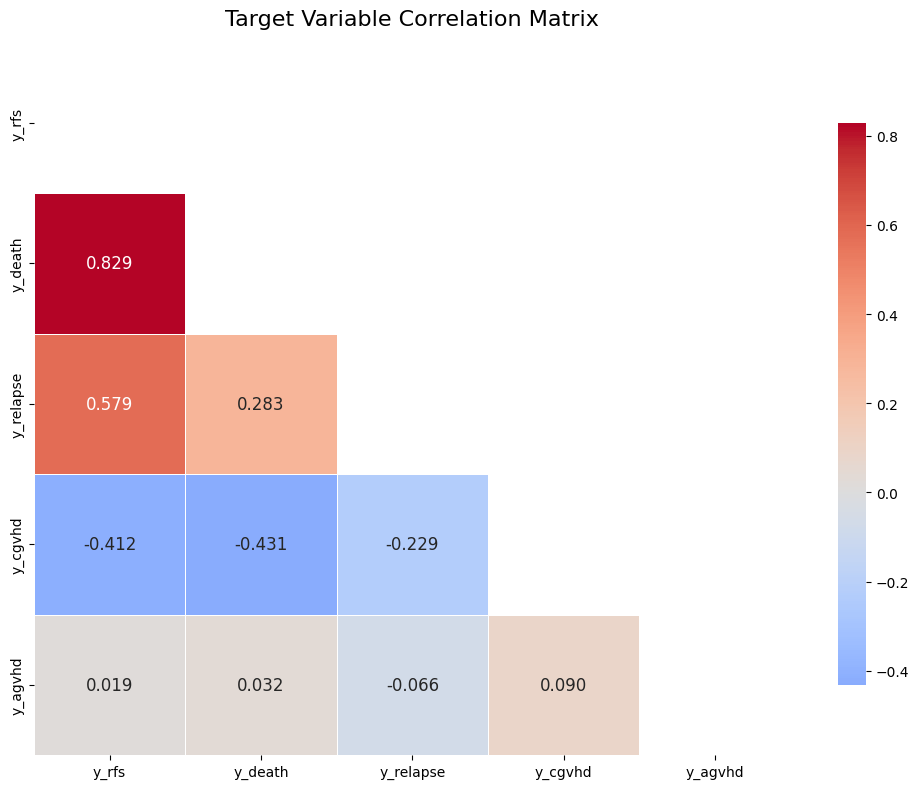


Strongest correlations between targets:
  Variable 1 Variable 2  Correlation
0    y_death      y_rfs     0.828568
1  y_relapse      y_rfs     0.579226
4    y_cgvhd    y_death    -0.431490
3    y_cgvhd      y_rfs    -0.411849
2  y_relapse    y_death     0.282874

🎯 2. Class Distribution Analysis


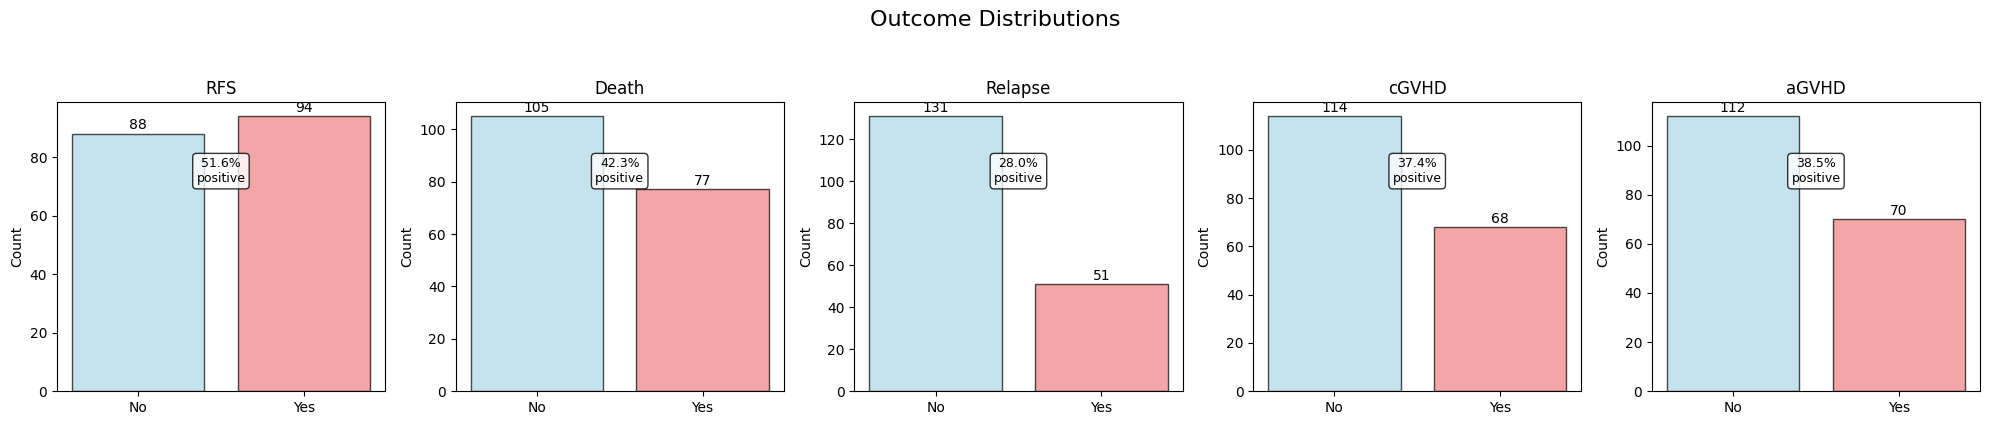


📊 3. Key Feature Distribution Analysis


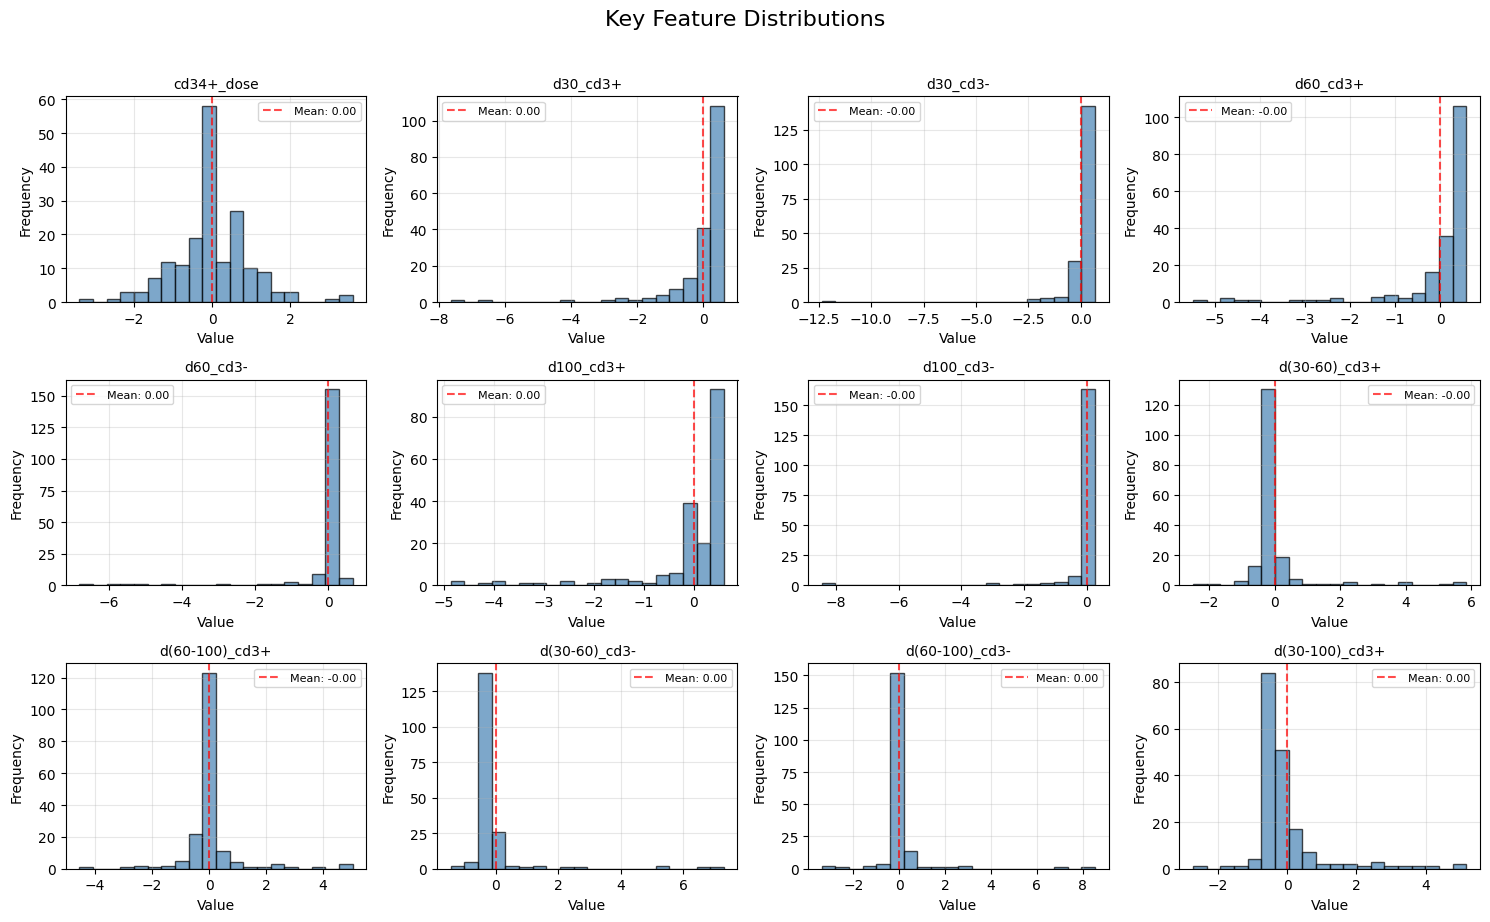

In [20]:
def create_comprehensive_eda(X, y_classification):
    """
    Create comprehensive exploratory data analysis visualizations.
    """
    print("📊 Creating comprehensive exploratory data analysis...")
    
    # 1. TARGET VARIABLE CORRELATIONS
    print("\n📈 1. Target Variable Correlation Analysis")
    
    if not y_classification.empty and len(y_classification.columns) > 1:
        correlation_matrix = y_classification.corr()
        
        plt.figure(figsize=(10, 8))
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(
            correlation_matrix,
            mask=mask,
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt='.3f',
            annot_kws={"size": 12},
            linewidths=0.5,
            cbar_kws={"shrink": 0.8}
        )
        plt.title('Target Variable Correlation Matrix', fontsize=16, pad=20)
        plt.tight_layout()
        plt.show()
        
        # Find strongest correlations
        corr_values = correlation_matrix.mask(mask).stack().reset_index()
        corr_values.columns = ['Variable 1', 'Variable 2', 'Correlation']
        corr_values = corr_values.sort_values('Correlation', key=abs, ascending=False)
        
        print("\nStrongest correlations between targets:")
        print(corr_values.head())
    
    # 2. CLASS DISTRIBUTION ANALYSIS
    print("\n🎯 2. Class Distribution Analysis")
    
    if not y_classification.empty:
        target_names = ['RFS', 'Death', 'Relapse', 'cGVHD', 'aGVHD']
        n_targets = min(len(y_classification.columns), len(target_names))
        
        fig, axes = plt.subplots(1, n_targets, figsize=(4 * n_targets, 4))
        if n_targets == 1:
            axes = [axes]
        
        for i, (col, name) in enumerate(zip(y_classification.columns[:n_targets], target_names[:n_targets])):
            counts = y_classification[col].value_counts().sort_index()
            
            bars = axes[i].bar(
                ['No', 'Yes'],
                [counts.get(0, 0), counts.get(1, 0)],
                color=['lightblue', 'lightcoral'],
                alpha=0.7,
                edgecolor='black'
            )
            
            axes[i].set_title(f'{name}', fontsize=12)
            axes[i].set_ylabel('Count')
            
            # Add value labels on bars
            for bar, count in zip(bars, [counts.get(0, 0), counts.get(1, 0)]):
                height = bar.get_height()
                axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                           f'{count}', ha='center', va='bottom', fontsize=10)
            
            # Add percentage
            total = counts.sum()
            if total > 0:
                yes_pct = (counts.get(1, 0) / total) * 100
                axes[i].text(0.5, max(counts) * 0.8, f'{yes_pct:.1f}%\npositive',
                           ha='center', va='center', fontsize=9,
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.suptitle('Outcome Distributions', fontsize=16, y=1.05)
        plt.tight_layout()
        plt.show()
    
    # 3. FEATURE DISTRIBUTION ANALYSIS
    print("\n📊 3. Key Feature Distribution Analysis")
    
    # Focus on key chimerism features
    chimerism_cols = [col for col in X.columns if any(x in col.lower() for x in ['cd3', 'chimerism'])]
    key_features = chimerism_cols[:12] if chimerism_cols else X.columns[:12]
    
    if key_features:
        n_features = len(key_features)
        n_cols = min(4, n_features)
        n_rows = (n_features + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        elif n_cols == 1:
            axes = axes.reshape(-1, 1)
        
        for i, feature in enumerate(key_features):
            row, col = i // n_cols, i % n_cols
            
            # Create histogram
            axes[row, col].hist(X[feature].dropna(), bins=20, alpha=0.7, color='steelblue', edgecolor='black')
            axes[row, col].set_title(f'{feature}', fontsize=10)
            axes[row, col].set_xlabel('Value')
            axes[row, col].set_ylabel('Frequency')
            axes[row, col].grid(True, alpha=0.3)
            
            # Add basic statistics
            mean_val = X[feature].mean()
            axes[row, col].axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.2f}')
            axes[row, col].legend(fontsize=8)
        
        # Hide empty subplots
        for i in range(len(key_features), n_rows * n_cols):
            row, col = i // n_cols, i % n_cols
            axes[row, col].set_visible(False)
        
        plt.suptitle('Key Feature Distributions', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()

# Run EDA
create_comprehensive_eda(X_preprocessed, y_classification_processed)

## 8. Pattern-Outcome Association Analysis

Analyze relationships between chimerism patterns and transplant outcomes.

🔍 Analyzing pattern-outcome associations...


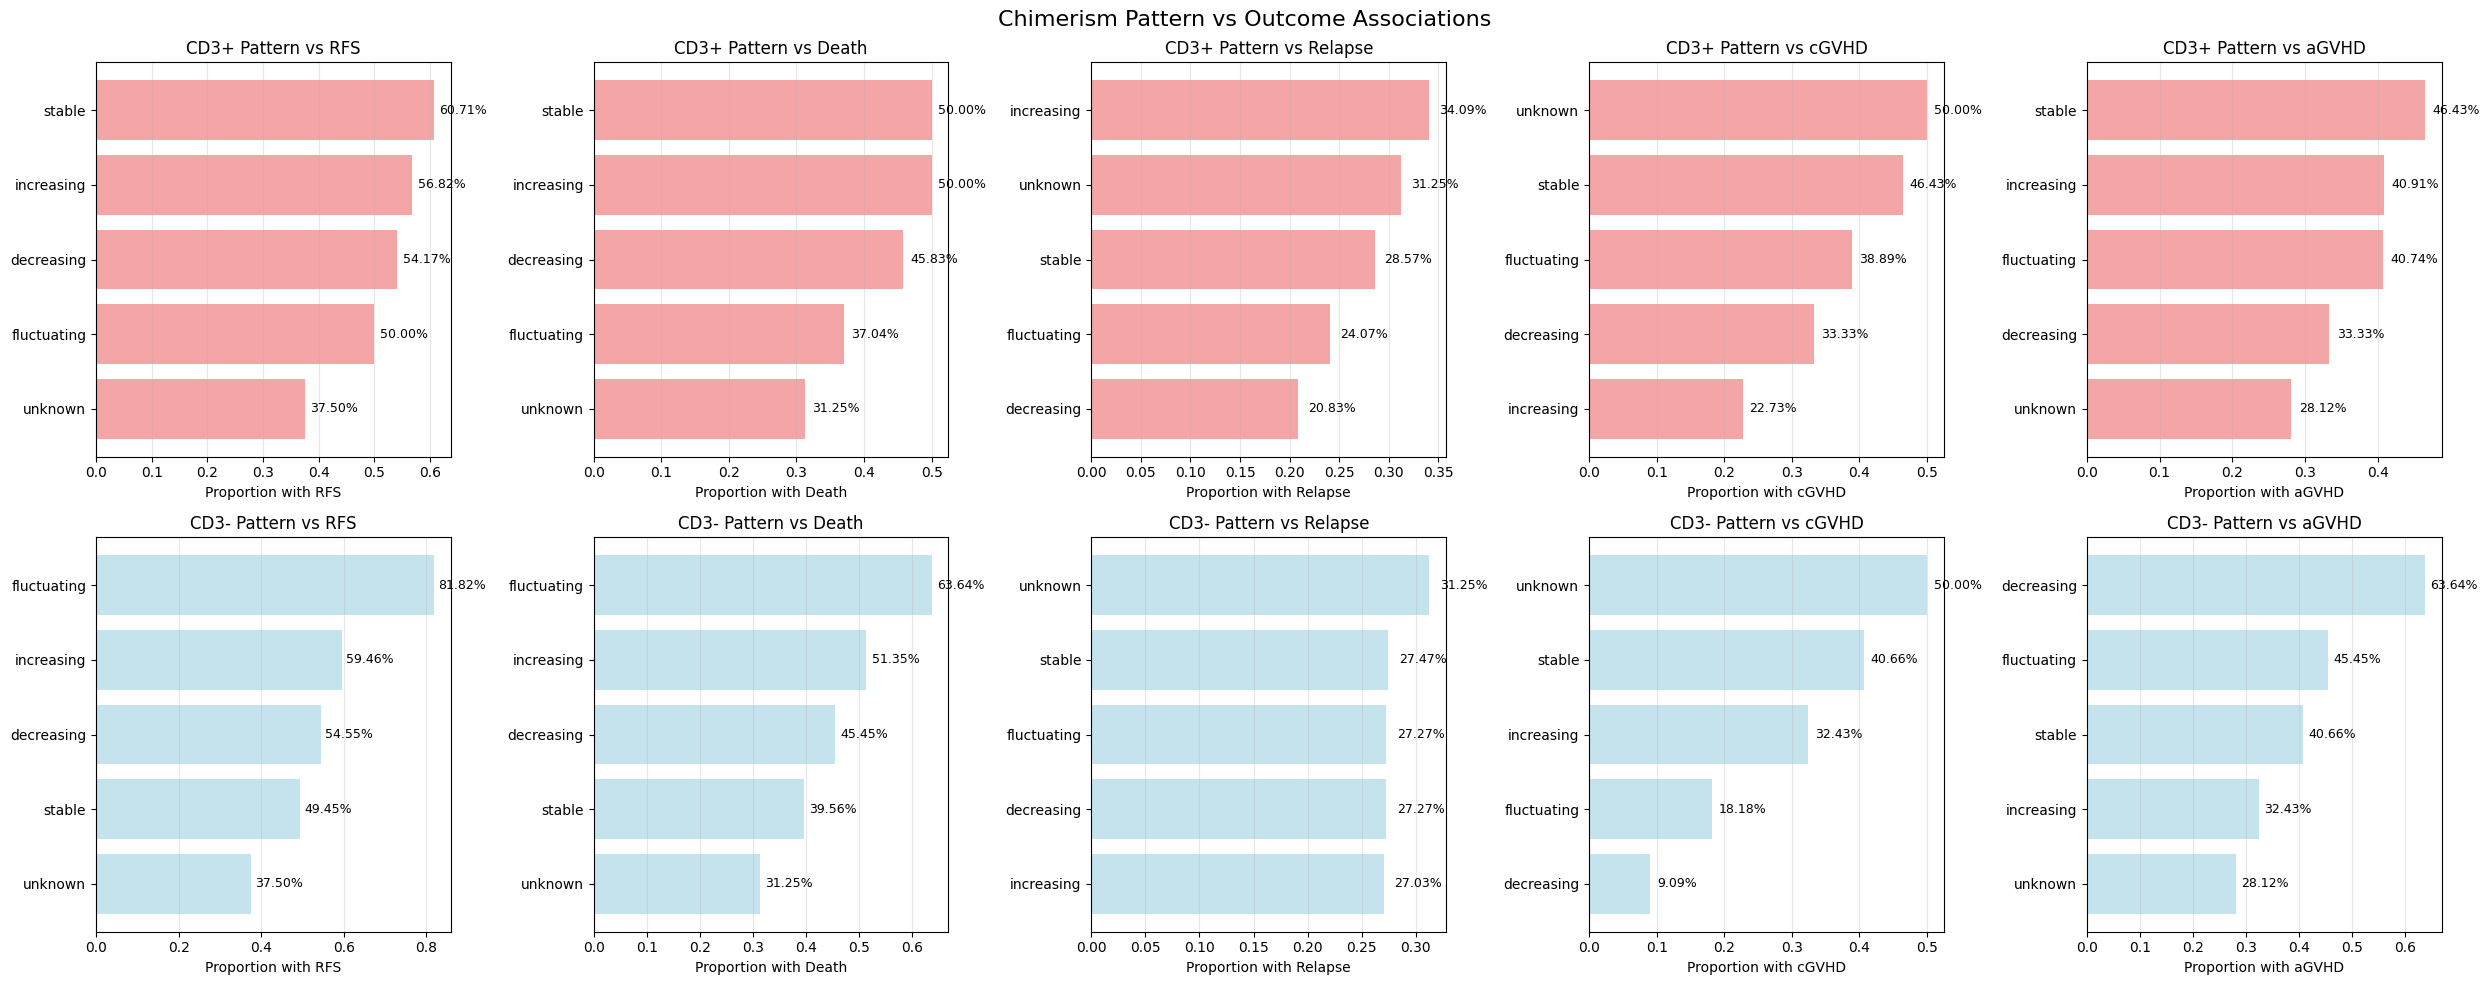

In [21]:
def analyze_pattern_outcome_associations(df_patterns, y_classification):
    """
    Analyze associations between chimerism patterns and transplant outcomes.
    """
    print("🔍 Analyzing pattern-outcome associations...")
    
    # Check if pattern columns exist
    if 'cd3+_simple_pattern' not in df_patterns.columns:
        print("⚠️ Pattern columns not found. Skipping analysis.")
        return
    
    # Get aligned data
    common_indices = df_patterns.index.intersection(y_classification.index)
    df_patterns_aligned = df_patterns.loc[common_indices]
    y_aligned = y_classification.loc[common_indices]
    
    target_names = ['RFS', 'Death', 'Relapse', 'cGVHD', 'aGVHD']
    
    # Create visualization
    fig, axes = plt.subplots(2, len(y_aligned.columns), figsize=(5 * len(y_aligned.columns), 10))
    
    for i, (col, name) in enumerate(zip(y_aligned.columns, target_names[:len(y_aligned.columns)])):
        # CD3+ patterns
        crosstab_cd3pos = pd.crosstab(
            df_patterns_aligned['cd3+_simple_pattern'],
            y_aligned[col],
            normalize='index'
        )
        
        if 1 in crosstab_cd3pos.columns:
            relapse_props = crosstab_cd3pos[1].sort_values(ascending=True)
            
            axes[0, i].barh(range(len(relapse_props)), relapse_props.values,
                           color='lightcoral', alpha=0.7)
            axes[0, i].set_yticks(range(len(relapse_props)))
            axes[0, i].set_yticklabels(relapse_props.index)
            axes[0, i].set_xlabel(f'Proportion with {name}')
            axes[0, i].set_title(f'CD3+ Pattern vs {name}')
            axes[0, i].grid(axis='x', alpha=0.3)
            
            # Add value labels
            for j, v in enumerate(relapse_props.values):
                axes[0, i].text(v + 0.01, j, f'{v:.2%}', va='center', fontsize=9)
        
        # CD3- patterns
        crosstab_cd3neg = pd.crosstab(
            df_patterns_aligned['cd3-_simple_pattern'],
            y_aligned[col],
            normalize='index'
        )
        
        if 1 in crosstab_cd3neg.columns:
            relapse_props = crosstab_cd3neg[1].sort_values(ascending=True)
            
            axes[1, i].barh(range(len(relapse_props)), relapse_props.values,
                           color='lightblue', alpha=0.7)
            axes[1, i].set_yticks(range(len(relapse_props)))
            axes[1, i].set_yticklabels(relapse_props.index)
            axes[1, i].set_xlabel(f'Proportion with {name}')
            axes[1, i].set_title(f'CD3- Pattern vs {name}')
            axes[1, i].grid(axis='x', alpha=0.3)
            
            # Add value labels
            for j, v in enumerate(relapse_props.values):
                axes[1, i].text(v + 0.01, j, f'{v:.2%}', va='center', fontsize=9)
    
    plt.suptitle('Chimerism Pattern vs Outcome Associations', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

# Analyze pattern associations
if 'cd3+_simple_pattern' in df_with_patterns.columns:
    analyze_pattern_outcome_associations(df_with_patterns, y_classification_processed)

## 9. Feature Selection and Optimization

Implement advanced feature selection with multiple methods.

In [22]:
def optimize_feature_selection(X, y, task="classification", method="select_k_best"):
    """
    Perform hyperparameter tuning for feature selection methods.
    
    This function tests different feature set sizes and returns the optimal selection.
    """
    # Choose appropriate scoring function and model
    if task == "classification":
        score_func = f_classif
        model = RandomForestClassifier(random_state=42, n_estimators=100)
        scoring = 'accuracy'
    else:
        score_func = f_regression
        model = RandomForestRegressor(random_state=42, n_estimators=100)
        scoring = 'neg_mean_squared_error'
    
    if method == "select_k_best":
        # Test Fibonacci sequence k values (optimal for feature selection)
        k_values = [1, 2, 3, 5, 8, 13, 21, 34]
        k_values = [k for k in k_values if k <= X.shape[1]]
        
        best_k = k_values[0]
        best_score = -np.inf
        best_selector = None
        
        for k in k_values:
            selector = SelectKBest(score_func=score_func, k=k)
            X_selected = selector.fit_transform(X, y)
            
            # Cross-validation score
            scores = cross_val_score(model, X_selected, y, cv=5, scoring=scoring)
            score = np.mean(scores)
            
            if score > best_score:
                best_k, best_score = k, score
                best_selector = selector
        
        # Get selected feature names
        selected_features = X.columns[best_selector.get_support()].tolist()
        print(f"   Optimal k={best_k}, score={best_score:.3f}")
        print(f"   Selected features: {selected_features}")
        
        return best_selector.transform(X), selected_features, best_k
    
    elif method == "rfe":
        # Test different numbers of features
        n_features = [1, 2, 3, 5, 8, 13, 21]
        n_features = [n for n in n_features if n <= X.shape[1]]
        
        best_n = n_features[0]
        best_score = -np.inf
        best_selector = None
        
        for n in n_features:
            selector = RFE(model, n_features_to_select=n)
            X_selected = selector.fit_transform(X, y)
            
            scores = cross_val_score(model, X_selected, y, cv=5, scoring=scoring)
            score = np.mean(scores)
            
            if score > best_score:
                best_n, best_score = n, score
                best_selector = selector
        
        selected_features = X.columns[best_selector.get_support()].tolist()
        return best_selector.transform(X), selected_features, best_n
    
    elif method == "feature_importance":
        # Train model and get feature importance
        model.fit(X, y)
        importance_scores = model.feature_importances_
        
        # Test different thresholds
        thresholds = np.percentile(importance_scores, [50, 60, 70, 80, 90])
        
        best_threshold = thresholds[0]
        best_score = -np.inf
        best_features = None
        
        for threshold in thresholds:
            selected_features = X.columns[importance_scores > threshold].tolist()
            
            if len(selected_features) == 0:
                continue
            
            X_selected = X[selected_features]
            scores = cross_val_score(model, X_selected, y, cv=5, scoring=scoring)
            score = np.mean(scores)
            
            if score > best_score:
                best_threshold, best_score = threshold, score
                best_features = selected_features
        
        return X[best_features].values, best_features, len(best_features)

# Create feature set definitions
def create_feature_sets_for_analysis():
    """
    Define different feature sets for comparative analysis.
    """
    feature_sets = {
        "dynamics_only": {
            "name": "Chimerism Dynamics Only",
            "features": ["d(30-60)_cd3+", "d(60-100)_cd3+", "d(30-60)_cd3-", "d(60-100)_cd3-"],
            "description": "Only time-point differences"
        },
        "timepoints_only": {
            "name": "Time Points Only",
            "features": ["d30_cd3+", "d30_cd3-", "d60_cd3+", "d60_cd3-", "d100_cd3+", "d100_cd3-"],
            "description": "Raw chimerism values at each time point"
        },
        "statistics_only": {
            "name": "Statistical Features Only",
            "features": ["mean_cd3+", "mean_cd3-", "std_cd3+", "std_cd3-", "cv_cd3+", "cv_cd3-"],
            "description": "Statistical summaries across time points"
        },
        "patterns_only": {
            "name": "Pattern Features Only",
            "features": ["cd3+_pattern_encoded", "cd3-_pattern_encoded"],
            "description": "Encoded trend patterns"
        },
        "minimal_predictive": {
            "name": "Minimal Predictive Set",
            "features": ["d(60-100)_cd3+", "d100_cd3-", "std_cd3+"],
            "description": "Top 3 most predictive features based on analysis"
        }
    }
    
    return feature_sets

print("✅ Feature selection functions defined")
print("📊 Available feature selection methods: select_k_best, rfe, feature_importance")
print("🎯 Available feature sets:", list(create_feature_sets_for_analysis().keys()))

✅ Feature selection functions defined
📊 Available feature selection methods: select_k_best, rfe, feature_importance
🎯 Available feature sets: ['dynamics_only', 'timepoints_only', 'statistics_only', 'patterns_only', 'minimal_predictive']


## 10. Machine Learning Model Training Pipeline

Implement comprehensive ML pipeline with multiple algorithms and hyperparameter tuning.

=== Starting Model Training with Different Balance Settings ===

🔹 FEATURE SELECTION: SELECT_K_BEST | BALANCE: NONE 🔹

🔹 Training models for Relapse (Balance method: none) 🔹
Applying select_k_best feature selection...
   Optimal k=1, score=0.775
   Selected features: ['std_cd3+']
  Training Random Forest...
    Accuracy: 0.726 (±0.097)
    F1-Score: 0.621 (±0.096)
    ROC AUC: 0.612
  Training SVM...
    Accuracy: 0.731 (±0.045)
    F1-Score: 0.483 (±0.064)
    ROC AUC: 0.492
  Training Naive Bayes...
    Accuracy: 0.720 (±0.066)
    F1-Score: 0.540 (±0.050)
    ROC AUC: 0.506


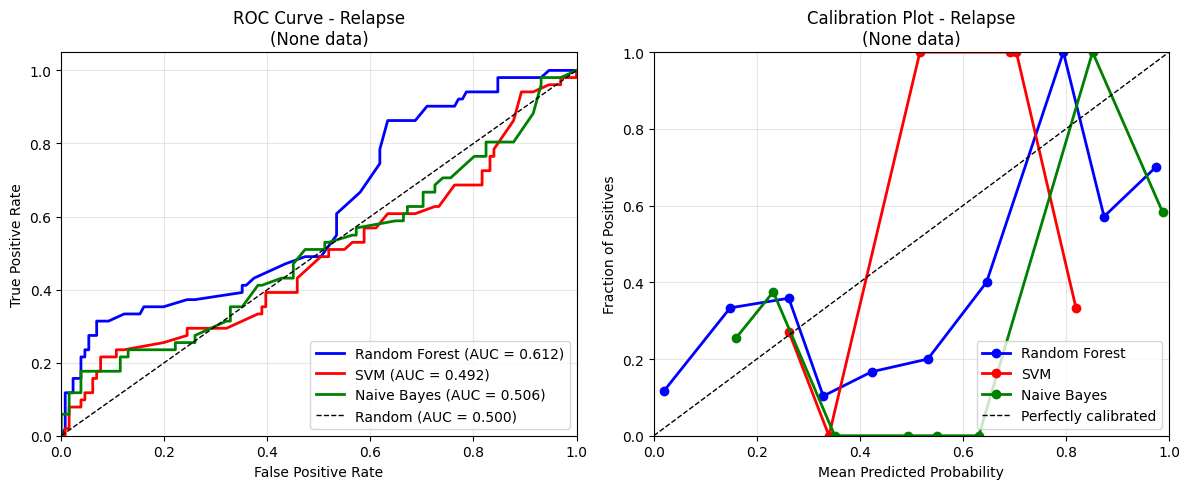


🔹 FEATURE SELECTION: RFE | BALANCE: NONE 🔹

🔹 Training models for Relapse (Balance method: none) 🔹
Applying rfe feature selection...
  Training Random Forest...
    Accuracy: 0.731 (±0.045)
    F1-Score: 0.510 (±0.054)
    ROC AUC: 0.620
  Training SVM...
    Accuracy: 0.753 (±0.043)
    F1-Score: 0.539 (±0.069)
    ROC AUC: 0.491
  Training Naive Bayes...
    Accuracy: 0.682 (±0.072)
    F1-Score: 0.520 (±0.058)
    ROC AUC: 0.554


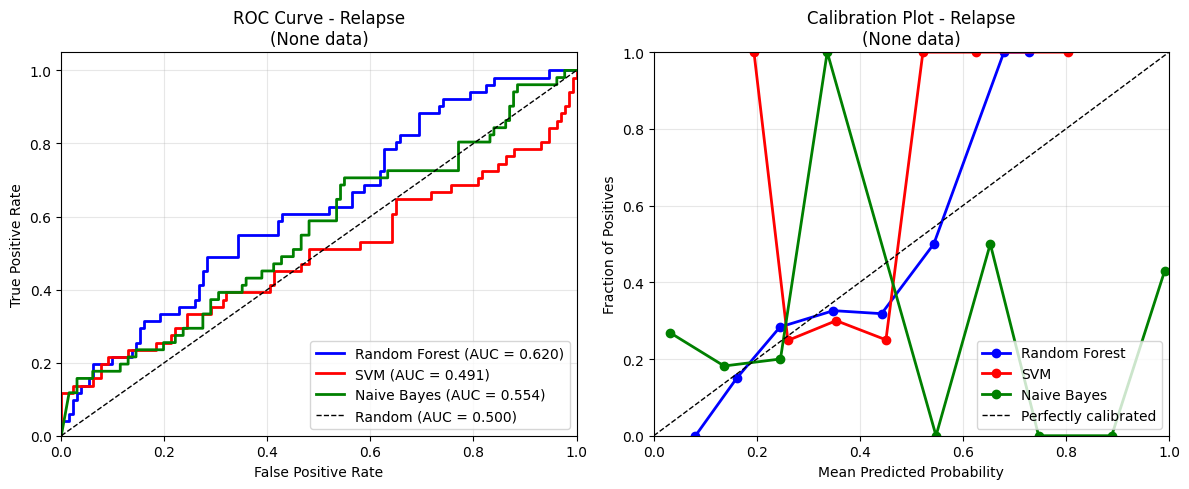


🔹 FEATURE SELECTION: FEATURE_IMPORTANCE | BALANCE: NONE 🔹

🔹 Training models for Relapse (Balance method: none) 🔹
Applying feature_importance feature selection...
  Training Random Forest...
    Accuracy: 0.731 (±0.061)
    F1-Score: 0.512 (±0.086)
    ROC AUC: 0.602
  Training SVM...
    Accuracy: 0.753 (±0.043)
    F1-Score: 0.539 (±0.069)
    ROC AUC: 0.525
  Training Naive Bayes...
    Accuracy: 0.693 (±0.077)
    F1-Score: 0.530 (±0.073)
    ROC AUC: 0.544


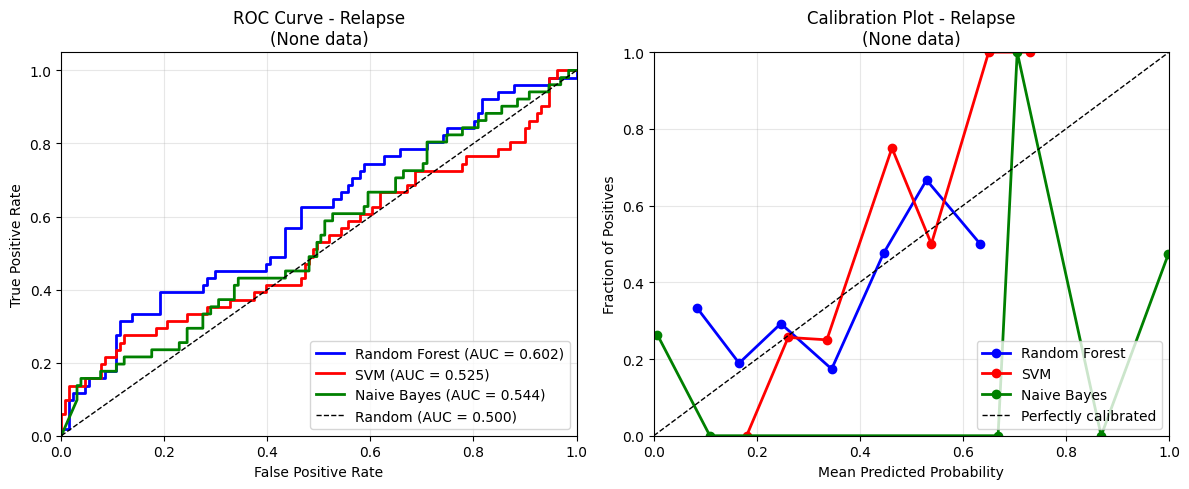


🔹 FEATURE SELECTION: SELECT_K_BEST | BALANCE: DOWNSAMPLE 🔹

🔹 Training models for Relapse (Balance method: downsample) 🔹
   Original distribution: Class 0: 131, Class 1: 51
   Balanced distribution: Class 0: 51, Class 1: 51
Applying select_k_best feature selection...
   Optimal k=34, score=0.628
   Selected features: ['disease_risk_index', 'time_from_diagnosis_to_alloSCT', 'disease_state_at_transplant', 'mrd_status_prior_to_transplant', 'thymo', 'steroids_for_gvhd_prophylaxis', 'ptcy', 'ebv_reactivation', 'd100_cd3+', 'd100_cd3-', 'pre_transplant', 'mrd_status_day_100', 'mrd_status_technique', 'd(60-100)_cd3+', 'd(30-60)_cd3-', 'd(60-100)_cd3-', 'd(30-100)_cd3+', 'd(30-100)_cd3-', 'mean_cd3+', 'std_cd3+', 'cv_cd3+', 'min_cd3+', 'range_cd3+', 'mean_cd3-', 'std_cd3-', 'cv_cd3-', 'min_cd3-', 'range_cd3-', 'pct_change_30_100_cd3-', 'slope_cd3+', 'slope_cd3-', 'cd3+_trend_pattern', 'cd3-_simple_pattern', 'cd3-_pattern_encoded']
  Training Random Forest...
    Accuracy: 0.597 (±0.090)
    F

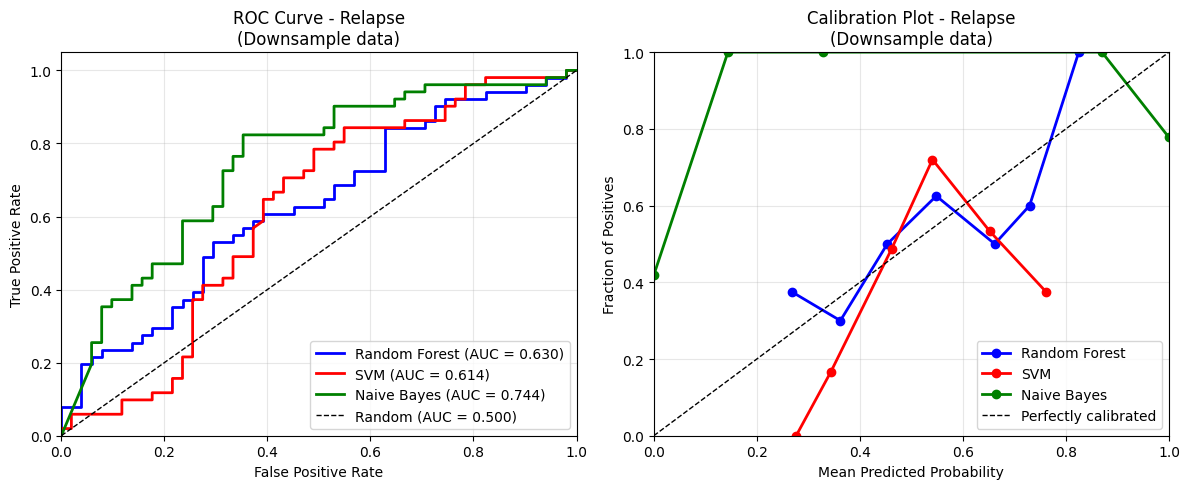


🔹 FEATURE SELECTION: RFE | BALANCE: DOWNSAMPLE 🔹

🔹 Training models for Relapse (Balance method: downsample) 🔹
   Original distribution: Class 0: 131, Class 1: 51
   Balanced distribution: Class 0: 51, Class 1: 51
Applying rfe feature selection...
  Training Random Forest...
    Accuracy: 0.519 (±0.084)
    F1-Score: 0.516 (±0.083)
    ROC AUC: 0.547
  Training SVM...
    Accuracy: 0.586 (±0.154)
    F1-Score: 0.572 (±0.153)
    ROC AUC: 0.582
  Training Naive Bayes...
    Accuracy: 0.637 (±0.098)
    F1-Score: 0.602 (±0.076)
    ROC AUC: 0.678


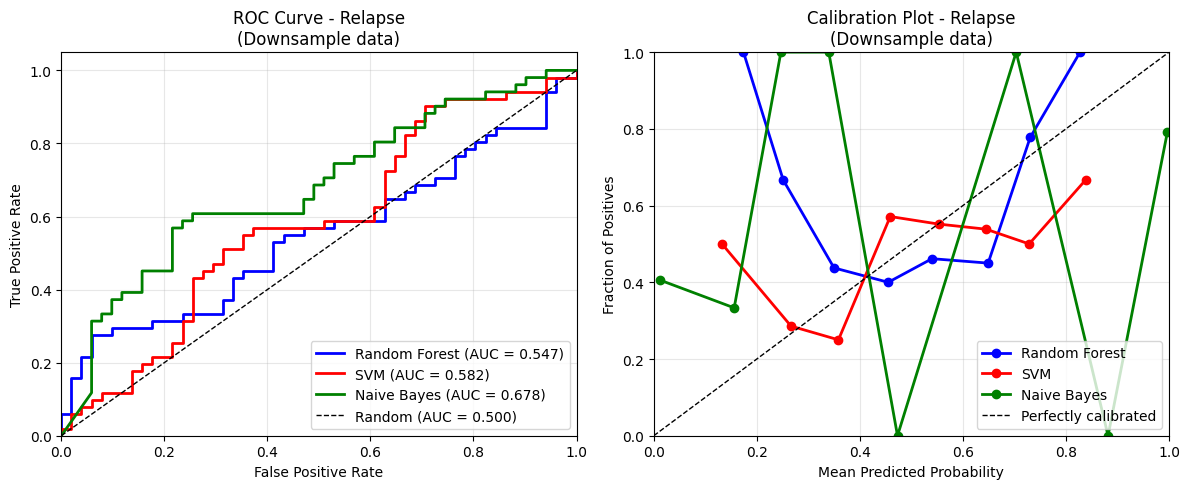


🔹 FEATURE SELECTION: FEATURE_IMPORTANCE | BALANCE: DOWNSAMPLE 🔹

🔹 Training models for Relapse (Balance method: downsample) 🔹
   Original distribution: Class 0: 131, Class 1: 51
   Balanced distribution: Class 0: 51, Class 1: 51
Applying feature_importance feature selection...
  Training Random Forest...
    Accuracy: 0.518 (±0.128)
    F1-Score: 0.517 (±0.128)
    ROC AUC: 0.554
  Training SVM...
    Accuracy: 0.577 (±0.137)
    F1-Score: 0.572 (±0.135)
    ROC AUC: 0.396
  Training Naive Bayes...
    Accuracy: 0.637 (±0.092)
    F1-Score: 0.611 (±0.068)
    ROC AUC: 0.676


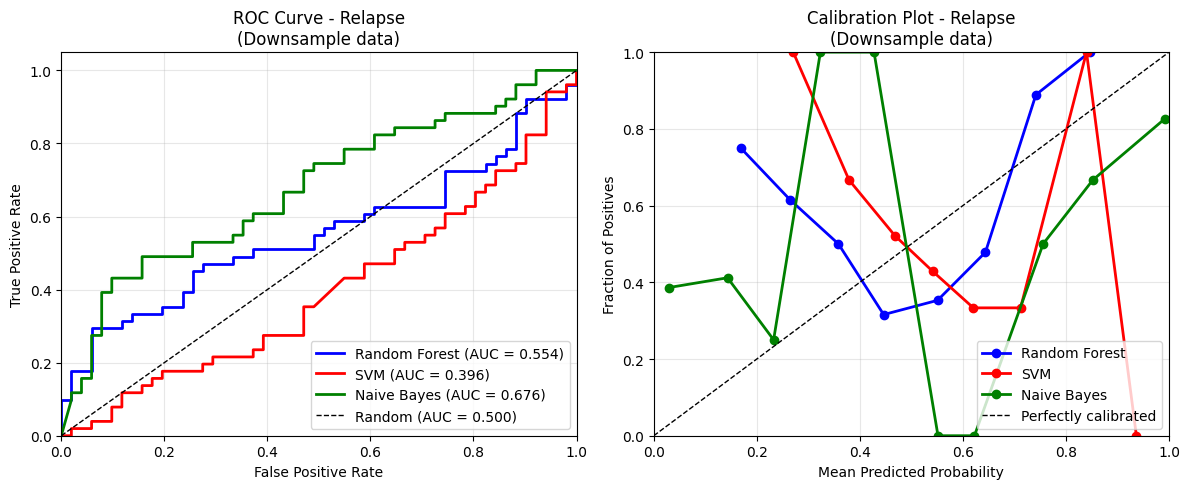


🎉 ALL MODEL TRAINING COMPLETED 🎉


In [23]:
def train_classification_models(X, y_classification, feature_selection_method="select_k_best", cv=5, balance_method="none"):
    """
    Train classification models with cross-validation and feature selection for each target.
    
    This function combines:
    - GridSearchCV hyperparameter tuning from aml_mds_organized
    - Optimal k selection from basic_analysis_organized
    - Unbalanced and balanced (downsampling) options
    - ROC curve and Calibration plot visualization
    
    Parameters:
    -----------
    balance_method : str, default="none"
        - "none": Use unbalanced data
        - "downsample": Apply downsampling to balance classes
    """
    from sklearn.utils import resample
    from sklearn.metrics import roc_curve, auc, roc_auc_score
    from sklearn.calibration import calibration_curve
    from sklearn.model_selection import cross_val_predict
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Define hyperparameter grids
    param_grids = {
        "Random Forest": {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        "SVM": {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto']
        },
        "Naive Bayes": {}
    }
    
    # Initialize classifiers
    classifiers = {
        "Random Forest": RandomForestClassifier(random_state=42),
        "SVM": SVC(random_state=42, probability=True),
        "Naive Bayes": GaussianNB()
    }
    
    # target_names = ["RFS", "Death", "Relapse", "cGVHD", "aGVHD"]
    target_names = ["Relapse"]
    target_name_in_df = ["y_relapse"]
    
    classification_results = {}
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    # for idx, label in enumerate(y_classification.columns):
    for idx, label in enumerate(target_name_in_df):
        
        target_name = target_names[idx] if idx < len(target_names) else f"Target_{idx}"
        print(f"\n🔹 Training models for {target_name} (Balance method: {balance_method}) 🔹")
        
        # Get target variable and ensure no missing values
        y_label = y_classification[label].dropna()
        X_label = X.loc[y_label.index]
        
        # Check if we have multiple classes
        if len(y_label.unique()) <= 1:
            print(f"⚠️ Skipping {target_name}: Only one class present")
            continue
        
        # Apply balancing method if requested
        if balance_method == "downsample":
            # Separate classes
            class_0 = y_label[y_label == 0].index
            class_1 = y_label[y_label == 1].index
            
            print(f"   Original distribution: Class 0: {len(class_0)}, Class 1: {len(class_1)}")
            
            if len(class_0) != len(class_1):
                # Downsample the majority class
                if len(class_0) > len(class_1):
                    # Downsample class 0
                    class_0_downsampled = resample(class_0, 
                                                 replace=False,
                                                 n_samples=len(class_1),
                                                 random_state=42)
                    balanced_indices = list(class_0_downsampled) + list(class_1)
                else:
                    # Downsample class 1
                    class_1_downsampled = resample(class_1,
                                                 replace=False,
                                                 n_samples=len(class_0),
                                                 random_state=42)
                    balanced_indices = list(class_0) + list(class_1_downsampled)
                
                # Update data with balanced sample
                X_label = X_label.loc[balanced_indices]
                y_label = y_label.loc[balanced_indices]
                print(f"   Balanced distribution: Class 0: {(y_label == 0).sum()}, Class 1: {(y_label == 1).sum()}")
        
        # Apply feature selection
        print(f"Applying {feature_selection_method} feature selection...")
        X_selected, selected_features, n_features = optimize_feature_selection(
            X_label, y_label, task="classification", method=feature_selection_method
        )
        
        classification_results[target_name] = {
            'selected_features': selected_features,
            'n_features': n_features,
            'balance_method': balance_method,
            'models': {},
            'roc_data': {},
            'calibration_data': {}
        }

        for model_name, model in classifiers.items():
            print(f"  Training {model_name}...")
            
            # Hyperparameter tuning
            if param_grids[model_name]:  # If there are parameters to tune
                grid_search = GridSearchCV(
                    model, param_grids[model_name], cv=3, scoring='accuracy', n_jobs=-1
                )
                grid_search.fit(X_selected, y_label)
                best_model = grid_search.best_estimator_
                best_params = grid_search.best_params_
            else:
                # For models without hyperparameters (like Naive Bayes)
                best_model = model
                best_params = {}
                best_model.fit(X_selected, y_label)
            
            # Cross-validation evaluation
            accuracy_scores = cross_val_score(
                best_model, X_selected, y_label, cv=kf, scoring='accuracy'
            )
            f1_scores = cross_val_score(
                best_model, X_selected, y_label, cv=kf, scoring='f1_macro'
            )
            
            # Generate predictions for detailed report and ROC/Calibration analysis
            y_pred = cross_val_predict(best_model, X_selected, y_label, cv=kf)
            y_proba = cross_val_predict(best_model, X_selected, y_label, cv=kf, method='predict_proba')[:, 1]
            
            # Store results
            classification_results[target_name]['models'][model_name] = {
                "best_model_params": best_params,
                "accuracy": np.mean(accuracy_scores),
                "accuracy_std": np.std(accuracy_scores),
                "f1_score": np.mean(f1_scores),
                "f1_std": np.std(f1_scores),
                "report": classification_report(y_label, y_pred, output_dict=True),
                "model": best_model,
                "y_true": y_label.values,
                "y_pred": y_pred,
                "y_proba": y_proba
            }
            
            # Calculate ROC data
            fpr, tpr, _ = roc_curve(y_label, y_proba)
            roc_auc = auc(fpr, tpr)
            classification_results[target_name]['roc_data'][model_name] = {
                'fpr': fpr,
                'tpr': tpr,
                'auc': roc_auc
            }
            
            # Calculate calibration data
            fraction_of_positives, mean_predicted_value = calibration_curve(y_label, y_proba, n_bins=10)
            classification_results[target_name]['calibration_data'][model_name] = {
                'fraction_of_positives': fraction_of_positives,
                'mean_predicted_value': mean_predicted_value
            }
            
            print(f"    Accuracy: {np.mean(accuracy_scores):.3f} (±{np.std(accuracy_scores):.3f})")
            print(f"    F1-Score: {np.mean(f1_scores):.3f} (±{np.std(f1_scores):.3f})")
            print(f"    ROC AUC: {roc_auc:.3f}")

        # Plot ROC curves for this target
        plt.figure(figsize=(12, 5))
        
        # ROC Curve subplot
        plt.subplot(1, 2, 1)
        colors = ['blue', 'red', 'green']
        for i, (model_name, roc_data) in enumerate(classification_results[target_name]['roc_data'].items()):
            plt.plot(roc_data['fpr'], roc_data['tpr'], 
                    color=colors[i], linewidth=2,
                    label=f'{model_name} (AUC = {roc_data["auc"]:.3f})')
        
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC = 0.500)')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {target_name}\n({balance_method.title()} data)')
        plt.legend(loc="lower right")
        plt.grid(alpha=0.3)
        
        # Calibration plot subplot
        plt.subplot(1, 2, 2)
        for i, (model_name, cal_data) in enumerate(classification_results[target_name]['calibration_data'].items()):
            plt.plot(cal_data['mean_predicted_value'], cal_data['fraction_of_positives'], 
                    marker='o', linewidth=2, color=colors[i], label=model_name)
        
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Perfectly calibrated')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('Mean Predicted Probability')
        plt.ylabel('Fraction of Positives')
        plt.title(f'Calibration Plot - {target_name}\n({balance_method.title()} data)')
        plt.legend(loc="lower right")
        plt.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    return classification_results

# Train models with different settings
print("=== Starting Model Training with Different Balance Settings ===")
feature_selection_methods = ["select_k_best", "rfe", "feature_importance"]
balance_methods = ["none", "downsample"]
classification_results_all = {}

for balance_method in balance_methods:
    classification_results_all[balance_method] = {}
    
    for method in feature_selection_methods:
        print(f"\n{'='*80}")
        print(f"🔹 FEATURE SELECTION: {method.upper()} | BALANCE: {balance_method.upper()} 🔹")
        print(f"{'='*80}")
        
        classification_results = train_classification_models(
            X_preprocessed, y_classification_processed,
            feature_selection_method=method, cv=5, balance_method=balance_method
        )
        
        classification_results_all[balance_method][method] = classification_results

print(f"\n{'='*80}")
print("🎉 ALL MODEL TRAINING COMPLETED 🎉")
print(f"{'='*80}")

## 11. Results Visualization and Performance Comparison

Create comprehensive visualizations to compare model performance.


=== VISUALIZING RESULTS FOR BOTH UNBALANCED AND BALANCED DATA ===


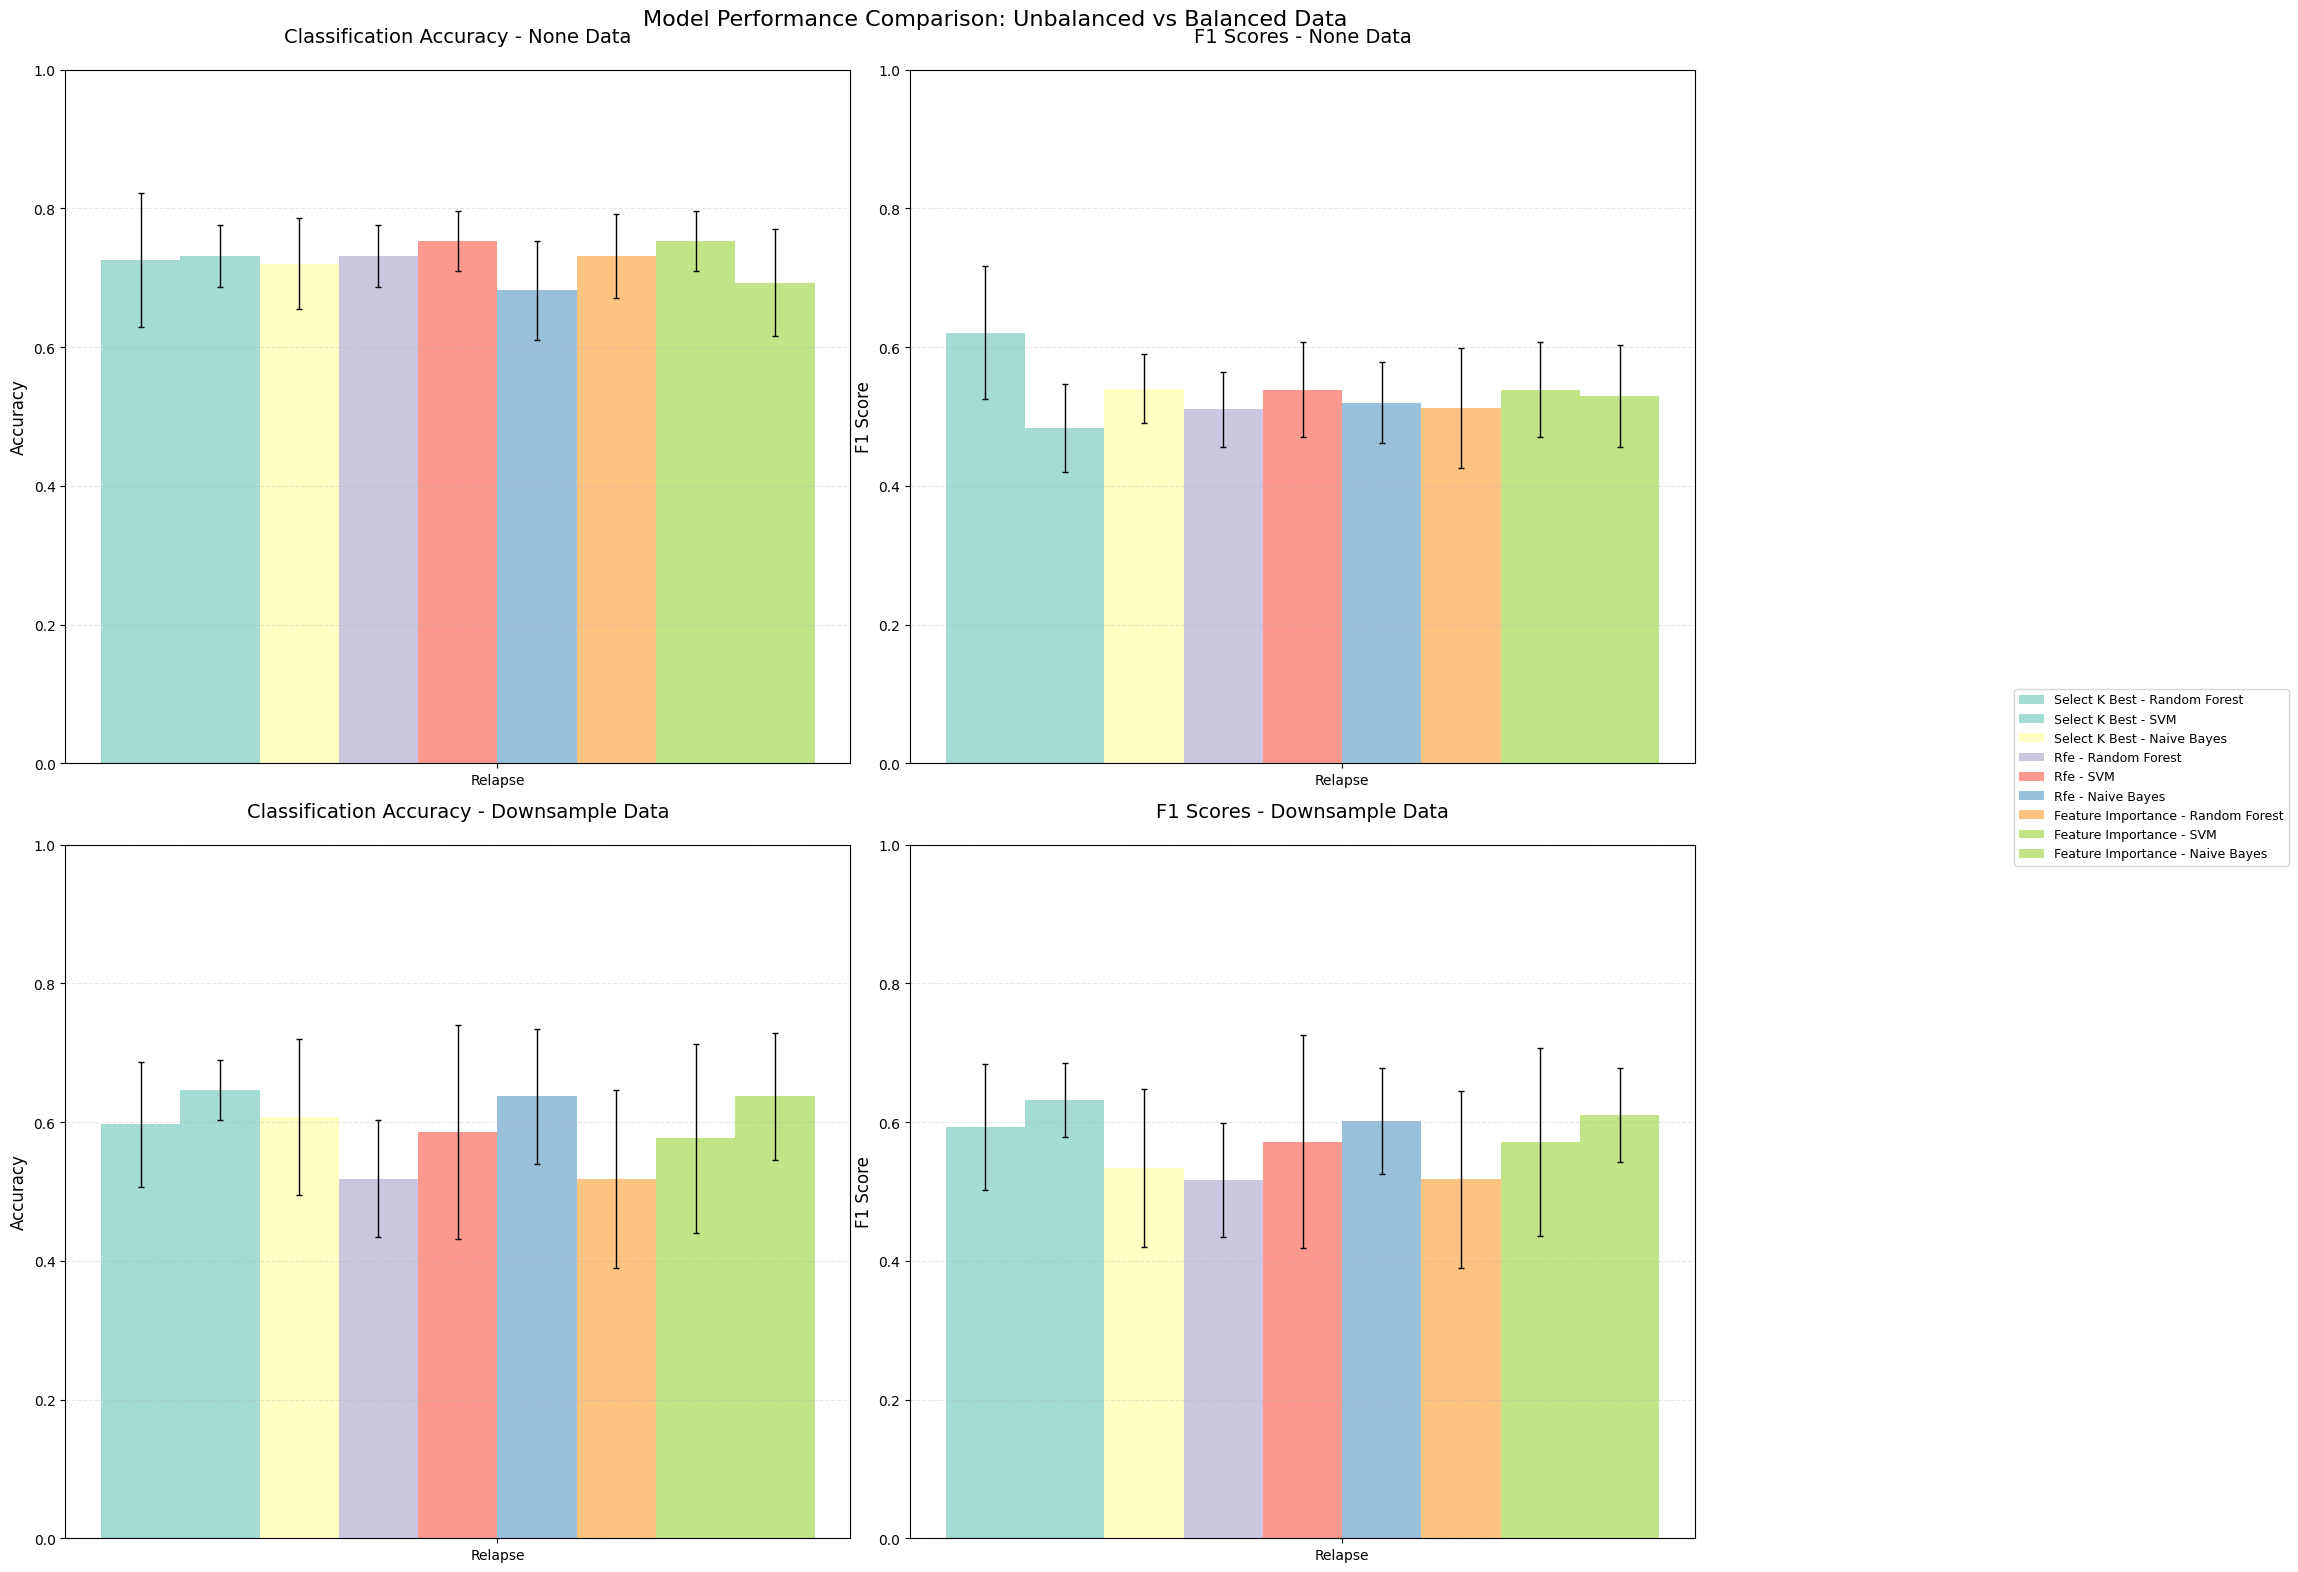

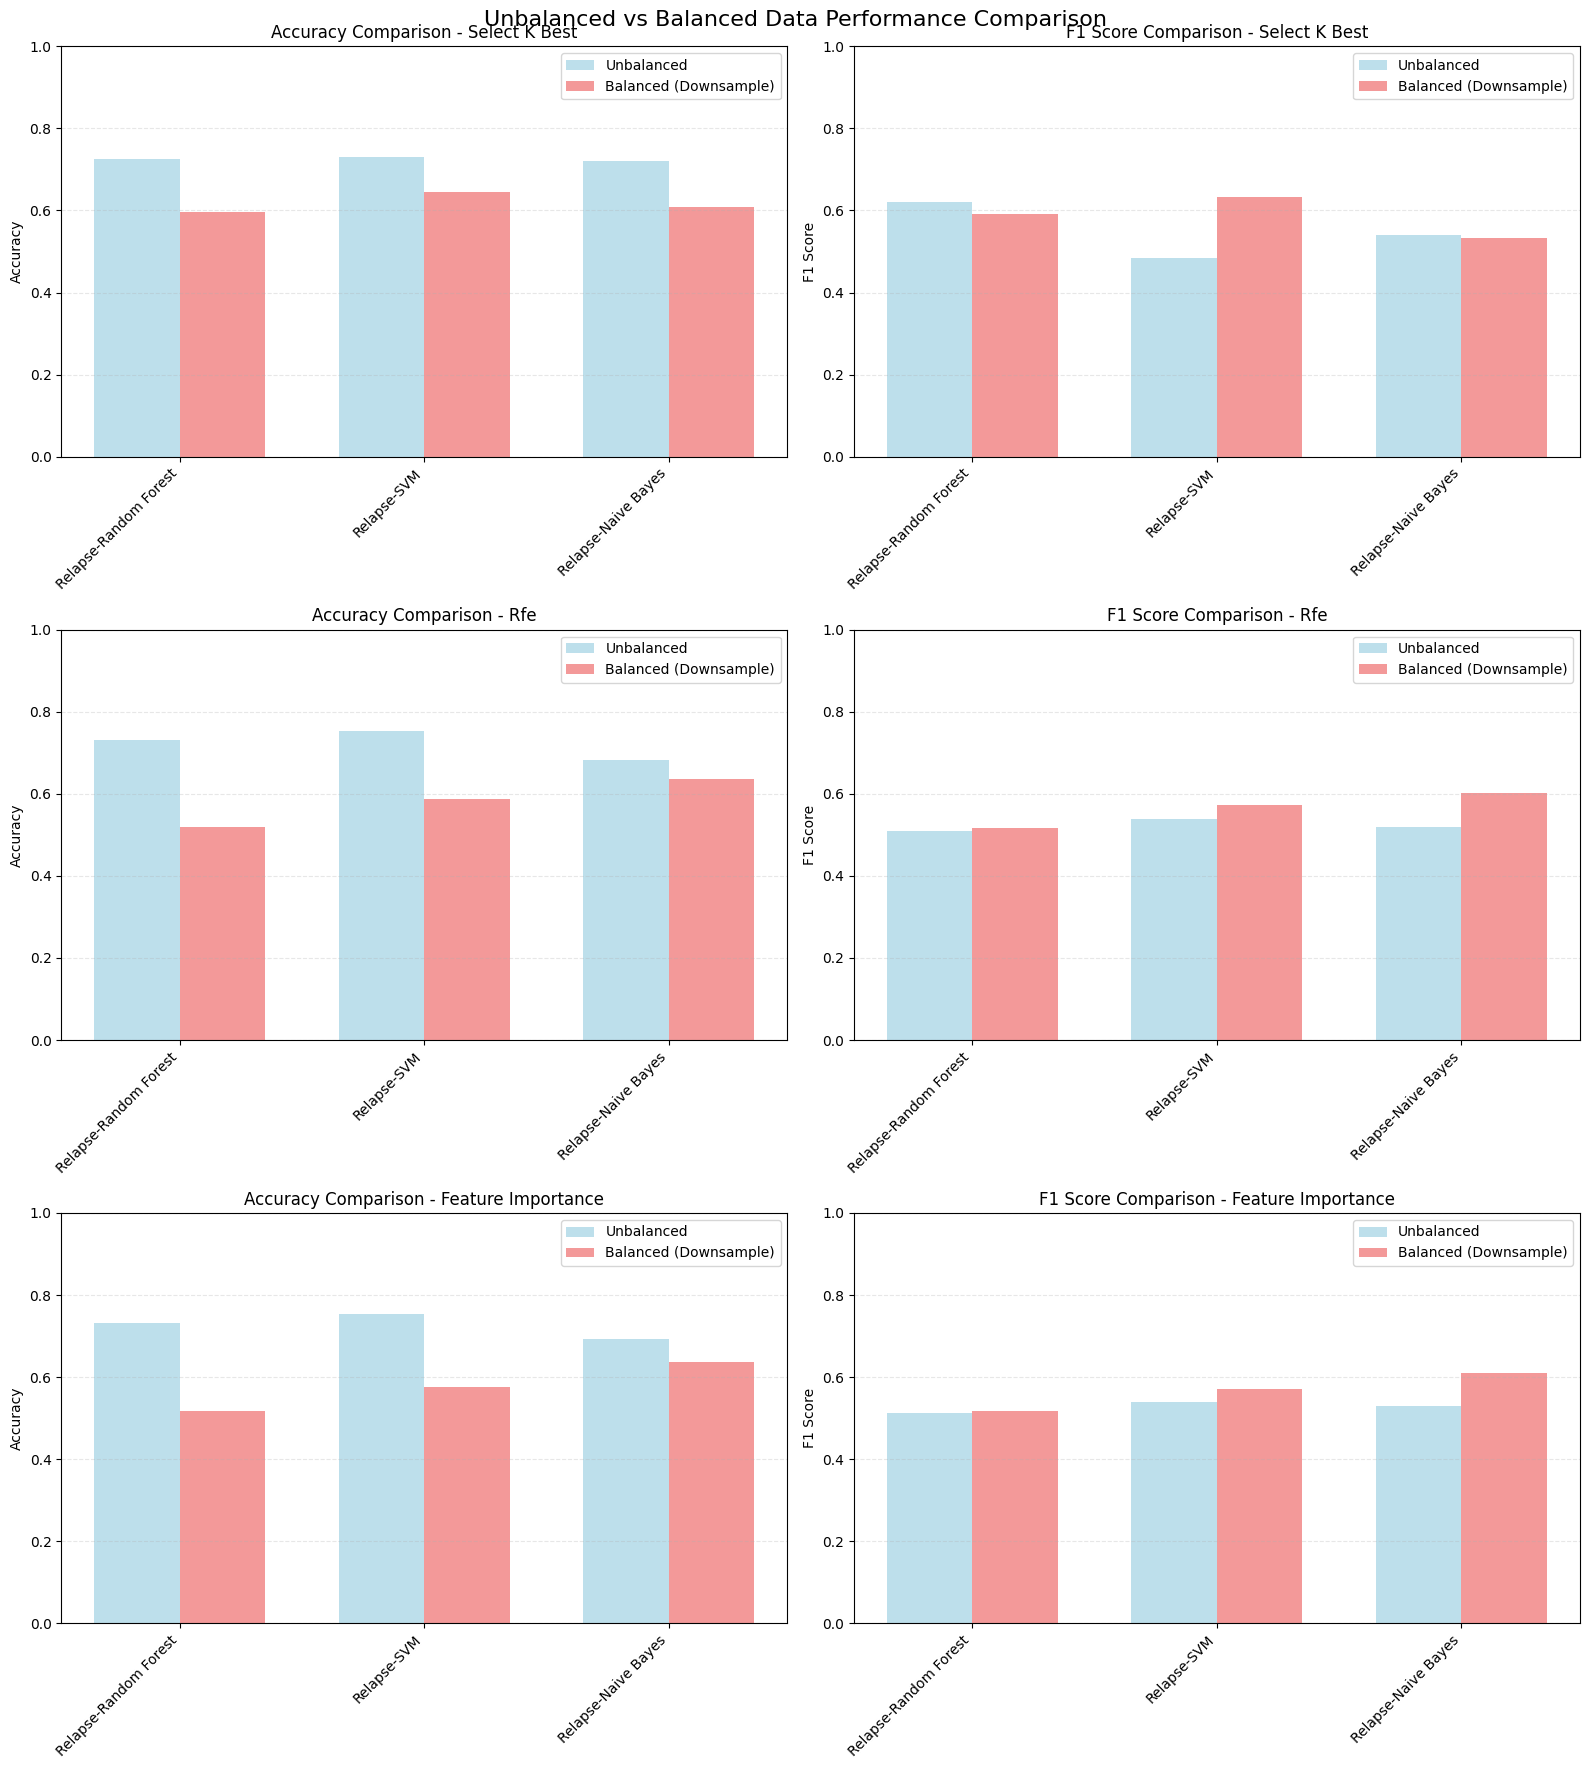

In [24]:
def plot_classification_results(results):
    """
    Create comprehensive visualization of classification results for both unbalanced and balanced data.
    
    The results parameter should have the structure:
    results = {
        'none': {feature_selection_method: {target: {models: ...}}},
        'downsample': {feature_selection_method: {target: {models: ...}}}
    }
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Check if we have balance methods in the top level
    if any(balance_method in results.keys() for balance_method in ['none', 'downsample']):
        # New structure with balance methods
        balance_methods = [method for method in ['none', 'downsample'] if method in results.keys()]
        
        # Create separate plots for each balance method
        fig, axes = plt.subplots(len(balance_methods), 2, figsize=(20, 8 * len(balance_methods)))
        if len(balance_methods) == 1:
            axes = axes.reshape(1, -1)
        
        colors = plt.cm.Set3(np.linspace(0, 1, 15))  # More colors for different combinations
        
        for balance_idx, balance_method in enumerate(balance_methods):
            ax1 = axes[balance_idx, 0]
            ax2 = axes[balance_idx, 1]
            
            balance_results = results[balance_method]
            methods = list(balance_results.keys())
            classifiers = ["Random Forest", "SVM", "Naive Bayes"]
            
            # Get all unique targets across all methods
            all_targets = set()
            for method in methods:
                all_targets.update(balance_results[method].keys())
            all_targets = sorted(list(all_targets))
            
            x = np.arange(len(all_targets))
            width = 0.25 / len(methods) if len(methods) > 0 else 0.25
            
            color_idx = 0
            
            for method_idx, method in enumerate(methods):
                for model_idx, model in enumerate(classifiers):
                    accuracies = []
                    accuracy_stds = []
                    f1_scores = []
                    f1_stds = []
                    
                    for target in all_targets:
                        if (target in balance_results[method] and 
                            'models' in balance_results[method][target] and
                            model in balance_results[method][target]['models']):
                            model_results = balance_results[method][target]['models'][model]
                            accuracies.append(model_results["accuracy"])
                            accuracy_stds.append(model_results["accuracy_std"])
                            f1_scores.append(model_results["f1_score"])
                            f1_stds.append(model_results["f1_std"])
                        else:
                            accuracies.append(0)
                            accuracy_stds.append(0)
                            f1_scores.append(0)
                            f1_stds.append(0)
                    
                    position = x + (method_idx * len(classifiers) + model_idx) * width
                    
                    # Plot accuracy
                    ax1.bar(position, accuracies, width=width,
                           label=f"{method.replace('_', ' ').title()} - {model}",
                           color=colors[color_idx % len(colors)], alpha=0.8)
                    ax1.errorbar(position, accuracies, yerr=accuracy_stds,
                                fmt='none', color='black', capsize=2, linewidth=1)
                    
                    # Plot F1 scores
                    ax2.bar(position, f1_scores, width=width,
                           label=f"{method.replace('_', ' ').title()} - {model}",
                           color=colors[color_idx % len(colors)], alpha=0.8)
                    ax2.errorbar(position, f1_scores, yerr=f1_stds,
                                fmt='none', color='black', capsize=2, linewidth=1)
                    
                    color_idx += 1
            
            # Customize accuracy subplot
            ax1.set_xticks(x + (len(methods) * len(classifiers) * width) / 2)
            ax1.set_xticklabels(all_targets, rotation=0)
            ax1.set_ylabel('Accuracy', fontsize=12)
            ax1.set_ylim(0, 1)
            ax1.set_title(f'Classification Accuracy - {balance_method.title()} Data', fontsize=14, pad=20)
            ax1.grid(axis="y", linestyle="--", alpha=0.3)
            
            # Customize F1 score subplot
            ax2.set_xticks(x + (len(methods) * len(classifiers) * width) / 2)
            ax2.set_xticklabels(all_targets, rotation=0)
            ax2.set_ylabel('F1 Score', fontsize=12)
            ax2.set_ylim(0, 1)
            ax2.set_title(f'F1 Scores - {balance_method.title()} Data', fontsize=14, pad=20)
            ax2.grid(axis="y", linestyle="--", alpha=0.3)
            
            # Add legend for the first row only
            if balance_idx == 0:
                handles, labels = ax1.get_legend_handles_labels()
                fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.5), fontsize=9)
        
        plt.suptitle('Model Performance Comparison: Unbalanced vs Balanced Data', fontsize=16, y=0.98)
        plt.tight_layout()
        plt.subplots_adjust(right=0.85)
        plt.show()
        
        # Create comparison plot
        plot_balance_method_comparison(results)
        
    else:
        # Original structure - fallback for backward compatibility
        methods = list(results.keys())
        classifiers = ["Random Forest", "SVM", "Naive Bayes"]
        
        # Create figure with subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))
        
        num_methods = len(methods)
        
        # Get all unique targets across all methods
        all_targets = set()
        for method in methods:
            all_targets.update(results[method].keys())
        all_targets = sorted(list(all_targets))
        
        x = np.arange(len(all_targets))
        width = 0.25 / num_methods
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(methods) * len(classifiers)))
        color_idx = 0
        
        for method_idx, method in enumerate(methods):
            for model_idx, model in enumerate(classifiers):
                accuracies = []
                accuracy_stds = []
                f1_scores = []
                f1_stds = []
                
                for target in all_targets:
                    if (target in results[method] and 
                        'models' in results[method][target] and
                        model in results[method][target]['models']):
                        model_results = results[method][target]['models'][model]
                        accuracies.append(model_results["accuracy"])
                        accuracy_stds.append(model_results["accuracy_std"])
                        f1_scores.append(model_results["f1_score"])
                        f1_stds.append(model_results["f1_std"])
                    else:
                        accuracies.append(0)
                        accuracy_stds.append(0)
                        f1_scores.append(0)
                        f1_stds.append(0)
                
                position = x + (method_idx * len(classifiers) + model_idx) * width
                
                # Plot accuracy
                ax1.bar(position, accuracies, width=width,
                       label=f"{method.replace('_', ' ').title()} - {model}",
                       color=colors[color_idx], alpha=0.8)
                ax1.errorbar(position, accuracies, yerr=accuracy_stds,
                            fmt='none', color='black', capsize=2, linewidth=1)
                
                # Plot F1 scores
                ax2.bar(position, f1_scores, width=width,
                       label=f"{method.replace('_', ' ').title()} - {model}",
                       color=colors[color_idx], alpha=0.8)
                ax2.errorbar(position, f1_scores, yerr=f1_stds,
                            fmt='none', color='black', capsize=2, linewidth=1)
                
                color_idx += 1
        
        # Customize accuracy subplot
        ax1.set_xticks(x + (num_methods * len(classifiers) * width) / 2)
        ax1.set_xticklabels(all_targets, rotation=0)
        ax1.set_ylabel('Accuracy', fontsize=12)
        ax1.set_ylim(0, 1)
        ax1.set_title('Classification Accuracy Across Feature Selection Methods', fontsize=14, pad=20)
        ax1.grid(axis="y", linestyle="--", alpha=0.3)
        
        # Customize F1 score subplot
        ax2.set_xticks(x + (num_methods * len(classifiers) * width) / 2)
        ax2.set_xticklabels(all_targets, rotation=0)
        ax2.set_ylabel('F1 Score', fontsize=12)
        ax2.set_ylim(0, 1)
        ax2.set_title('F1 Scores Across Feature Selection Methods', fontsize=14, pad=20)
        ax2.grid(axis="y", linestyle="--", alpha=0.3)
        
        # Add legend
        handles, labels = ax1.get_legend_handles_labels()
        fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.5), fontsize=10)
        
        plt.suptitle('Model Performance Comparison', fontsize=16, y=0.98)
        plt.tight_layout()
        plt.subplots_adjust(right=0.85)
        plt.show()


def plot_balance_method_comparison(results):
    """
    Create a direct comparison plot between unbalanced and balanced methods.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    balance_methods = [method for method in ['none', 'downsample'] if method in results.keys()]
    if len(balance_methods) < 2:
        print("⚠️ Need both 'none' and 'downsample' results for comparison")
        return
    
    # Get all feature selection methods and targets
    feature_methods = list(results['none'].keys())
    classifiers = ["Random Forest", "SVM", "Naive Bayes"]
    
    # Get all unique targets
    all_targets = set()
    for balance_method in balance_methods:
        for method in feature_methods:
            all_targets.update(results[balance_method][method].keys())
    all_targets = sorted(list(all_targets))
    
    # Create comparison visualization
    fig, axes = plt.subplots(len(feature_methods), 2, figsize=(16, 6 * len(feature_methods)))
    if len(feature_methods) == 1:
        axes = axes.reshape(1, -1)
    
    colors = ['lightblue', 'lightcoral', 'lightgreen']
    
    for method_idx, method in enumerate(feature_methods):
        ax1 = axes[method_idx, 0]
        ax2 = axes[method_idx, 1]
        
        # Collect data for this feature selection method
        unbalanced_data = {'accuracy': [], 'f1': []}
        balanced_data = {'accuracy': [], 'f1': []}
        labels = []
        
        for target in all_targets:
            for model_idx, model in enumerate(classifiers):
                # Unbalanced data
                if (target in results['none'][method] and 
                    'models' in results['none'][method][target] and
                    model in results['none'][method][target]['models']):
                    model_results = results['none'][method][target]['models'][model]
                    unbalanced_data['accuracy'].append(model_results["accuracy"])
                    unbalanced_data['f1'].append(model_results["f1_score"])
                else:
                    unbalanced_data['accuracy'].append(0)
                    unbalanced_data['f1'].append(0)
                
                # Balanced data
                if (target in results['downsample'][method] and 
                    'models' in results['downsample'][method][target] and
                    model in results['downsample'][method][target]['models']):
                    model_results = results['downsample'][method][target]['models'][model]
                    balanced_data['accuracy'].append(model_results["accuracy"])
                    balanced_data['f1'].append(model_results["f1_score"])
                else:
                    balanced_data['accuracy'].append(0)
                    balanced_data['f1'].append(0)
                
                labels.append(f"{target}-{model}")
        
        # Plot accuracy comparison
        x = np.arange(len(labels))
        width = 0.35
        
        ax1.bar(x - width/2, unbalanced_data['accuracy'], width, 
               label='Unbalanced', color='lightblue', alpha=0.8)
        ax1.bar(x + width/2, balanced_data['accuracy'], width,
               label='Balanced (Downsample)', color='lightcoral', alpha=0.8)
        
        ax1.set_ylabel('Accuracy')
        ax1.set_title(f'Accuracy Comparison - {method.replace("_", " ").title()}')
        ax1.set_xticks(x)
        ax1.set_xticklabels(labels, rotation=45, ha='right')
        ax1.legend()
        ax1.grid(axis="y", linestyle="--", alpha=0.3)
        ax1.set_ylim(0, 1)
        
        # Plot F1 comparison
        ax2.bar(x - width/2, unbalanced_data['f1'], width,
               label='Unbalanced', color='lightblue', alpha=0.8)
        ax2.bar(x + width/2, balanced_data['f1'], width,
               label='Balanced (Downsample)', color='lightcoral', alpha=0.8)
        
        ax2.set_ylabel('F1 Score')
        ax2.set_title(f'F1 Score Comparison - {method.replace("_", " ").title()}')
        ax2.set_xticks(x)
        ax2.set_xticklabels(labels, rotation=45, ha='right')
        ax2.legend()
        ax2.grid(axis="y", linestyle="--", alpha=0.3)
        ax2.set_ylim(0, 1)
    
    plt.suptitle('Unbalanced vs Balanced Data Performance Comparison', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()


# Plot results for both unbalanced and balanced data
print("\n=== VISUALIZING RESULTS FOR BOTH UNBALANCED AND BALANCED DATA ===")
plot_classification_results(classification_results_all)

🔍 Analyzing feature importance across all models...


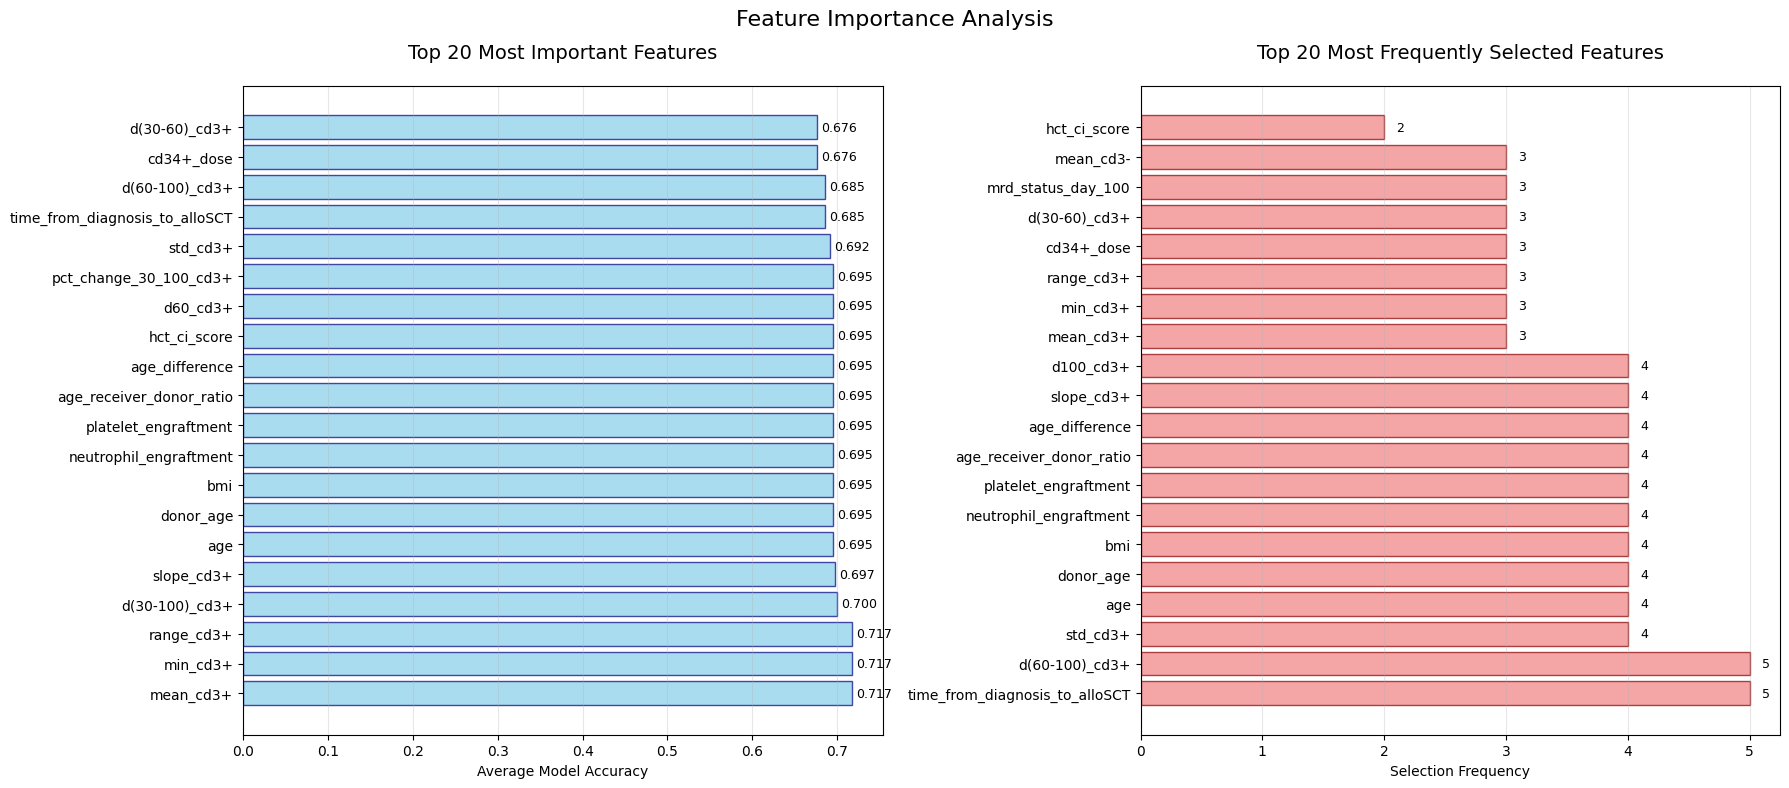


=== Feature Importance Summary ===

Total features analyzed: 46
Top 10 Most Important Features:
 1. mean_cd3+                      | Avg Accuracy: 0.717
 2. min_cd3+                       | Avg Accuracy: 0.717
 3. range_cd3+                     | Avg Accuracy: 0.717
 4. d(30-100)_cd3+                 | Avg Accuracy: 0.700
 5. slope_cd3+                     | Avg Accuracy: 0.697
 6. age                            | Avg Accuracy: 0.695
 7. donor_age                      | Avg Accuracy: 0.695
 8. bmi                            | Avg Accuracy: 0.695
 9. neutrophil_engraftment         | Avg Accuracy: 0.695
10. platelet_engraftment           | Avg Accuracy: 0.695


Chimerism Features in Top 20:
  - Count: 11/20
  - Features: mean_cd3+, min_cd3+, range_cd3+, d(30-100)_cd3+, slope_cd3+...


In [27]:
def plot_feature_importance_analysis(classification_results_all, X_preprocessed):
    """
    Create comprehensive feature importance analysis across all methods and targets.
    """
    print("🔍 Analyzing feature importance across all models...")
    
    # Aggregate feature importance scores
    feature_importance_scores = {}
    
    # Handle both nested and flat structure
    for method_or_balance, method_results in classification_results_all.items():
        # Check if this is a balance method (nested structure)
        if isinstance(method_results, dict) and any(key in ['select_k_best', 'rfe', 'feature_importance'] for key in method_results.keys()):
            # Nested structure: balance_method -> feature_method -> target -> results
            for feature_method, targets in method_results.items():
                for target, target_results in targets.items():
                    if 'selected_features' in target_results:
                        for feature in target_results['selected_features']:
                            if feature not in feature_importance_scores:
                                feature_importance_scores[feature] = []
                            
                            # Get the best model's accuracy for this target
                            best_accuracy = 0
                            if 'models' in target_results:
                                for model_name, model_results in target_results['models'].items():
                                    if 'accuracy' in model_results:
                                        best_accuracy = max(best_accuracy, model_results['accuracy'])
                            
                            feature_importance_scores[feature].append(best_accuracy)
        else:
            # Flat structure: method -> target -> results
            for target, target_results in method_results.items():
                if 'selected_features' in target_results:
                    for feature in target_results['selected_features']:
                        if feature not in feature_importance_scores:
                            feature_importance_scores[feature] = []
                        
                        # Get the best model's accuracy for this target
                        best_accuracy = 0
                        if 'models' in target_results:
                            for model_name, model_results in target_results['models'].items():
                                if 'accuracy' in model_results:
                                    best_accuracy = max(best_accuracy, model_results['accuracy'])
                        
                        feature_importance_scores[feature].append(best_accuracy)
    
    # Check if we have any features
    if not feature_importance_scores:
        print("⚠️ No features found in classification results. Checking available data...")
        print(f"Classification results structure: {list(classification_results_all.keys())}")
        
        # Try to extract from first available result
        sample_data = None
        for key1, val1 in classification_results_all.items():
            if isinstance(val1, dict):
                for key2, val2 in val1.items():
                    if isinstance(val2, dict) and val2:
                        sample_data = val2
                        break
                if sample_data:
                    break
        
        if sample_data:
            print(f"Sample result keys: {list(sample_data.keys())}")
            for target, target_data in sample_data.items():
                print(f"Target '{target}' keys: {list(target_data.keys()) if isinstance(target_data, dict) else type(target_data)}")
        
        return {}
    
    # Calculate average importance score for each feature
    feature_importance_avg = {
        feature: np.mean(scores) for feature, scores in feature_importance_scores.items()
    }
    
    # Sort features by importance
    sorted_features = sorted(feature_importance_avg.items(), key=lambda x: x[1], reverse=True)
    
    # Check if we have features to plot
    if not sorted_features:
        print("⚠️ No features to plot after sorting.")
        return {}
    
    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # 1. Top 20 Most Important Features
    top_features = sorted_features[:min(20, len(sorted_features))]
    
    if top_features:
        features, scores = zip(*top_features)
        
        y_pos = np.arange(len(features))
        ax1.barh(y_pos, scores, color='skyblue', edgecolor='navy', alpha=0.7)
        ax1.set_yticks(y_pos)
        ax1.set_yticklabels(features)
        ax1.set_xlabel('Average Model Accuracy')
        ax1.set_title(f'Top {len(top_features)} Most Important Features', fontsize=14, pad=20)
        ax1.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, v in enumerate(scores):
            ax1.text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=9)
    else:
        ax1.text(0.5, 0.5, 'No features to display', ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Top Most Important Features (None Found)', fontsize=14, pad=20)
    
    # 2. Feature Selection Frequency
    feature_selection_count = {feature: len(scores) for feature, scores in feature_importance_scores.items()}
    sorted_by_frequency = sorted(feature_selection_count.items(), key=lambda x: x[1], reverse=True)[:min(20, len(feature_selection_count))]
    
    if sorted_by_frequency:
        features_freq, counts = zip(*sorted_by_frequency)
        
        y_pos = np.arange(len(features_freq))
        ax2.barh(y_pos, counts, color='lightcoral', edgecolor='darkred', alpha=0.7)
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(features_freq)
        ax2.set_xlabel('Selection Frequency')
        ax2.set_title(f'Top {len(sorted_by_frequency)} Most Frequently Selected Features', fontsize=14, pad=20)
        ax2.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, v in enumerate(counts):
            ax2.text(v + 0.1, i, f'{v}', va='center', fontsize=9)
    else:
        ax2.text(0.5, 0.5, 'No features to display', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Most Frequently Selected Features (None Found)', fontsize=14, pad=20)
    
    plt.suptitle('Feature Importance Analysis', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n=== Feature Importance Summary ===")
    if sorted_features:
        print(f"\nTotal features analyzed: {len(sorted_features)}")
        print(f"Top {min(10, len(sorted_features))} Most Important Features:")
        for i, (feature, score) in enumerate(sorted_features[:10], 1):
            print(f"{i:2d}. {feature:<30} | Avg Accuracy: {score:.3f}")
        
        print(f"\n\nChimerism Features in Top {len(top_features)}:")
        chimerism_features = [f for f, _ in top_features if 'cd3' in f.lower() or 'chimerism' in f.lower()]
        print(f"  - Count: {len(chimerism_features)}/{len(top_features)}")
        if chimerism_features:
            print(f"  - Features: {', '.join(chimerism_features[:5])}...")
    else:
        print("No features were selected during the analysis.")
        print("This might indicate:")
        print("1. Feature selection failed to find suitable features")
        print("2. The data structure doesn't match expectations")
        print("3. All features were filtered out during preprocessing")
    
    return feature_importance_avg

# Analyze feature importance with error handling
try:
    feature_importance_scores = plot_feature_importance_analysis(classification_results_all, X_preprocessed)
except Exception as e:
    print(f"❌ Error in feature importance analysis: {str(e)}")
    print("Attempting to debug the classification results structure...")
    
    # Debug the structure
    print(f"classification_results_all keys: {list(classification_results_all.keys())}")
    for key, value in classification_results_all.items():
        print(f"\n{key}: {type(value)}")
        if isinstance(value, dict):
            print(f"  Subkeys: {list(value.keys())}")
            for subkey, subvalue in value.items():
                print(f"  {subkey}: {type(subvalue)}")
                if isinstance(subvalue, dict):
                    print(f"    Sub-subkeys: {list(subvalue.keys())}")

## 13. Advanced Clustering with K-Means and UMAP

Perform advanced clustering analysis with 3D visualization using UMAP dimensionality reduction.